<a href="https://colab.research.google.com/github/EricZhang660/spectrum_prediction/blob/main/spectrum_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## package import

In [1]:
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [2]:
!apt-get install -qq git

In [ ]:
from getpass import getpass
import os
os.environ['GITHUB_USERNAME'] = getpass('EricZhang660')
os.environ['GITHUB_TOKEN'] = getpass('GitHub token:')

In [2]:
from google.colab import drive

# Mount the Google Drive at "/content/drive"
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pubchempy
!pip install rdkit
!pip install joblib

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=79069b9efc13c722fe7147e0cbf25601ab886b1643928ac9b27b2af07adc46d3
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 63.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

import pubchempy
import ast

import torch.nn as nn
import torch

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import random

## Part 0, pre-process raw dataset

In [5]:
import sqlite3

conn = sqlite3.connect('/content/drive/My Drive/individualProject/data-20.db')
cursor = conn.cursor()

sql = """select name from sqlite_master where type='table' order by name"""
cursor.execute(sql)
result = cursor.fetchall()

# read the main data from database

data = pd.read_sql_query("SELECT * FROM main_data", conn)
conn.close()
data.head(20)

name       cas    formula  charge_mass_ratio  \
0   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 12   
1   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 16   
2   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 25   
3   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 26   
4   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 27   
5   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 28   
6   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 29   
7   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 30   
8   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 31   
9   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 32   
10  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 35   
11  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 36   
12  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 37   
13  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 38   
14  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 39   
15  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 40   
16  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 44   
17  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 46   
18  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 47   
19  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 48   

    peak_height  branch_ratio                     optional_fragment  
0            10      0.000150                                   ¹²C  
1            10      0.000150                     ¹⁶O,¹H2¹⁴N,¹²C¹H4  
2            30      0.000449                                ¹²C2¹H  
3           109      0.001633                        ¹²C¹⁴N,¹²C2¹H2  
4           119      0.001783                      ¹²C¹H¹⁴N,¹²C2¹H3  
5           179      0.002682              ¹²C¹⁶O,¹²C¹H2¹⁴N,¹²C2¹H4  
6            10      0.000150                    ¹²C¹H¹⁶O,¹²C¹H3¹⁴N  
7          2379      0.035640            ¹⁴N¹⁶O,¹²C¹H2¹⁶O,¹²C¹H4¹⁴N  
8            20      0.000300                    ¹H¹⁴N¹⁶O,¹²C¹H3¹⁶O  
9            20      0.000300              ¹⁶O2,¹H2¹⁴N¹⁶O,¹²C¹H4¹⁶O  
10           30      0.000449                          ³⁵Cl,¹H3¹⁶O2  
11          109      0.001633                   ¹H³⁵Cl,¹H4¹⁶O2,¹²C3  
12          629      0.009423                   ³⁷Cl,¹H2³⁵Cl,¹²C3¹H  
13          609      0.009124        ¹H³⁷Cl,¹H3³⁵Cl,¹²C2¹⁴N,¹²C3¹H2  
14          349      0.005228     ¹H2³⁷Cl,¹H4³⁵Cl,¹²C2¹H¹⁴N,¹²C3¹H3  
15           20      0.000300    ¹H3³⁷Cl,¹²C2¹⁶O,¹²C2¹H2¹⁴N,¹²C3¹H4  
16           20      0.000300       ¹²C¹⁶O2,¹²C¹H2¹⁴N¹⁶O,¹²C2¹H4¹⁶O  
17           70      0.001049       ¹⁴N¹⁶O2,¹²C¹H2¹⁶O2,¹²C¹H4¹⁴N¹⁶O  
18           70      0.001049          ¹H¹⁴N¹⁶O2,¹²C³⁵Cl,¹²C¹H3¹⁶O2  
19           50      0.000749  ¹H2¹⁴N¹⁶O2,¹²C¹H³⁵Cl,¹²C¹H4¹⁶O2,¹²C4

In [10]:
data.head(75)

name       cas    formula  charge_mass_ratio  \
0   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 12   
1   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 16   
2   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 25   
3   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 26   
4   Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                 27   
..                         ...       ...        ...                ...   
70  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                143   
71  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                157   
72  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                158   
73  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                159   
74  Benzene, 1-chloro-4-nitro-  100-00-5  C6H4ClNO2                160   

    peak_height  branch_ratio  \
0            10      0.000150   
1            10      0.000150   
2            30      0.000449   
3           109      0.001633   
4           119      0.001783   
..          ...           ...   
70           90      0.001348   
71         8749      0.131071   
72          609      0.009124   
73         2819      0.042232   
74          199      0.002981   

                                    optional_fragment  
0                                                 ¹²C  
1                                   ¹⁶O,¹H2¹⁴N,¹²C¹H4  
2                                              ¹²C2¹H  
3                                      ¹²C¹⁴N,¹²C2¹H2  
4                                    ¹²C¹H¹⁴N,¹²C2¹H3  
..                                                ...  
70  ¹²C5³⁷Cl¹⁴N¹⁶O2,¹²C5¹H2³⁵Cl¹⁴N¹⁶O2,¹²C6¹H2³⁷Cl...  
71              ¹²C6¹H2³⁷Cl¹⁴N¹⁶O2,¹²C6¹H4³⁵Cl¹⁴N¹⁶O2  
72                                 ¹²C6¹H3³⁷Cl¹⁴N¹⁶O2  
73                                 ¹²C6¹H4³⁷Cl¹⁴N¹⁶O2  
74  ¹³C¹²C5¹H4³⁷Cl¹⁴N¹⁶O2,¹²C6²H¹H3³⁷Cl¹⁴N¹⁶O2,¹²C...  

[75 rows x 7 columns]

In [ ]:
data['charge_mass_ratio'].describe()

count    448211.000000
mean         81.734400
std          50.074936
min           1.000000
25%          45.000000
50%          72.000000
75%         106.000000
max         609.000000
Name: charge_mass_ratio, dtype: float64

<Axes: ylabel='Frequency'>

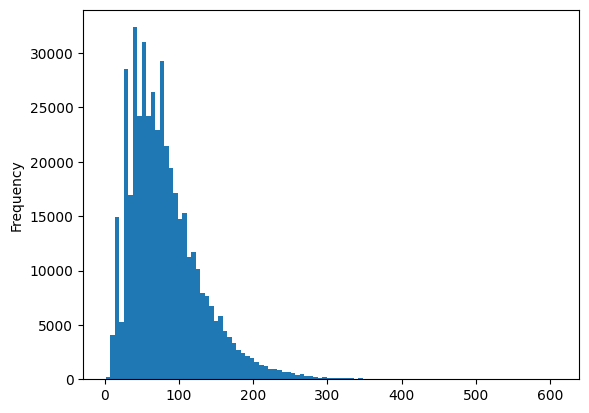

In [ ]:
# plot the distribution of charge mass ratio, I decide to fix the predicted mass spectrum as 300-length vector

data['charge_mass_ratio'].plot.hist(bins=100)

In [ ]:
results = pubchempy.get_compounds('(+)-p-Bromo-.alpha.-phenethylamine', 'name')

for l in results:
  print(l.isomeric_smiles)
  print(l.exact_mass)


CC(C1=CC=C(C=C1)Br)N
198.99966


In [ ]:
mol = Chem.MolFromSmiles('CC(C1=CC=C(C=C1)Br)N')

# Get the atoms in the molecule
atoms = mol.GetAtoms()

# Print the atomic numbers and symbols
for atom in atoms:
    atomic_num = atom.GetAtomicNum()
    symbol = atom.GetSymbol()
    print(f"Atomic number: {atomic_num}, Symbol: {symbol}")

# Get the bonds in the molecule
bonds = mol.GetBonds()

# Print the bond types and the indices of the atoms they connect
for bond in bonds:
    bond_type = bond.GetBondType()
    begin_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    print(f"Bond type: {bond_type}, Connected atoms: ({begin_idx}, {end_idx})")

Atomic number: 6, Symbol: C
Atomic number: 6, Symbol: C
Atomic number: 6, Symbol: C
Atomic number: 6, Symbol: C
Atomic number: 6, Symbol: C
Atomic number: 6, Symbol: C
Atomic number: 6, Symbol: C
Atomic number: 6, Symbol: C
Atomic number: 35, Symbol: Br
Atomic number: 7, Symbol: N
Bond type: SINGLE, Connected atoms: (0, 1)
Bond type: SINGLE, Connected atoms: (1, 2)
Bond type: AROMATIC, Connected atoms: (2, 3)
Bond type: AROMATIC, Connected atoms: (3, 4)
Bond type: AROMATIC, Connected atoms: (4, 5)
Bond type: AROMATIC, Connected atoms: (5, 6)
Bond type: AROMATIC, Connected atoms: (6, 7)
Bond type: SINGLE, Connected atoms: (5, 8)
Bond type: SINGLE, Connected atoms: (1, 9)
Bond type: AROMATIC, Connected atoms: (7, 2)


In [ ]:
# get the ECFP fingerprint

# https://blog.csdn.net/dreadlesss/article/details/105976113


mol = Chem.MolFromSmiles('CCO')
fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096)
# Convert the fingerprint to a binary string
fp_str = list(fp.ToBitString())
fp_str
#print(len(fp))
#print(fp_str[1])
'''
for i, st in enumerate(fp_str):
  if int(st) > 0:
    print(i)
    print(st)
#print(np.nonzero(fp_str))
'''


'\nfor i, st in enumerate(fp_str):\n  if int(st) > 0:\n    print(i)\n    print(st)\n#print(np.nonzero(fp_str))\n'

In [ ]:

# Create a molecule from a SMILES string
smiles = "CCO"
mol = Chem.MolFromSmiles(smiles)

# Set the desired radius and length of the ECFP
radius = 2
length = 2048

# Generate the ECFP
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=length)

# Convert the fingerprint to a binary string
fp_str = fp.ToBitString()

# Print the generated fingerprint
print(len(fp_str))


2048


In [ ]:
#data['mass_list'] = data.groupby('name').agg({'charge_mass_ratio': lambda x: x.tolist()})

processed = data.groupby('name').agg({'peak_height': lambda x: x.tolist()})
processed['charge_mass_ratio'] = data.groupby('name').agg({'charge_mass_ratio': lambda x: x.tolist()})
processed

peak_height  \
name                                                                                            
(+)-p-Bromo-.alpha.-phenethylamine          [18, 939, 59, 204, 689, 5454, 24, 121, 221, 57...   
(-)-1-(4-Bromophenyl)ethylamine             [60, 921, 100, 250, 1071, 160, 1001, 140, 10, ...   
(.eta.5-cyclopentadienyl)dicarbonylrhodium  [149, 199, 2529, 49, 499, 1299, 199, 99, 99, 5...   
(1-Hydroxy-2,2,2-trichloroethyl)formamide   [235, 596, 252, 198, 381, 1068, 302, 1346, 117...   
(1R,2R)-(+)-1-Phenylpropylene oxide         [48, 269, 2, 19, 277, 856, 231, 289, 19, 178, ...   
...                                                                                       ...   
trans-2-Pentenoic acid                      [90, 90, 60, 170, 911, 2823, 1191, 731, 240, 1...   
trans-3,4-Dimethylcyclopentanone            [349, 1320, 1112, 478, 443, 3099, 803, 4191, 8...   
trans-4-Methoxy-3-buten-2-one               [1, 19, 165, 794, 16, 4, 40, 370, 1041, 237, 1...   
trans-Cinnamic acid                         [10, 10, 90, 240, 30, 60, 10, 10, 120, 270, 65...   
trans-Crotonamide                           [20, 20, 60, 269, 159, 70, 30, 20, 90, 399, 10...   

                                                                            charge_mass_ratio  
name                                                                                           
(+)-p-Bromo-.alpha.-phenethylamine          [14, 15, 16, 26, 27, 28, 29, 30, 37, 38, 39, 4...  
(-)-1-(4-Bromophenyl)ethylamine             [14, 15, 16, 17, 18, 26, 27, 30, 36, 37, 38, 3...  
(.eta.5-cyclopentadienyl)dicarbonylrhodium  [65, 66, 103, 104, 112, 115, 116, 128, 129, 13...  
(1-Hydroxy-2,2,2-trichloroethyl)formamide   [35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...  
(1R,2R)-(+)-1-Phenylpropylene oxide         [14, 15, 18, 25, 26, 27, 28, 29, 31, 37, 38, 3...  
...                                                                                       ...  
trans-2-Pentenoic acid                      [12, 17, 18, 25, 26, 27, 28, 29, 30, 36, 37, 3...  
trans-3,4-Dimethylcyclopentanone            [15, 27, 28, 29, 38, 39, 40, 41, 42, 43, 53, 5...  
trans-4-Methoxy-3-buten-2-one               [12, 13, 14, 15, 16, 24, 25, 26, 27, 28, 29, 3...  
trans-Cinnamic acid                         [15, 25, 26, 27, 28, 29, 31, 36, 37, 38, 39, 4...  
trans-Crotonamide                           [12, 13, 14, 15, 16, 17, 18, 24, 25, 26, 27, 2...  

[7122 rows x 2 columns]

In [ ]:
def getSpectrum(mass_list, peak_list):
  # the ground-truth label data is fixed to 300-length vector
  spectrum = [0] * 300
  for i in range(len(mass_list)):
    # the minimum value of charge mass ratio is 1
    if mass_list[i] <= 300:
      spectrum[mass_list[i]-1] += peak_list[i]

  return spectrum



processed['spectrum'] = processed.apply(lambda x : getSpectrum(x['charge_mass_ratio'], x['peak_height']), axis=1)
processed = processed.reset_index()
processed

name  \
0             (+)-p-Bromo-.alpha.-phenethylamine   
1                (-)-1-(4-Bromophenyl)ethylamine   
2     (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3      (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4            (1R,2R)-(+)-1-Phenylpropylene oxide   
...                                          ...   
7117                      trans-2-Pentenoic acid   
7118            trans-3,4-Dimethylcyclopentanone   
7119               trans-4-Methoxy-3-buten-2-one   
7120                         trans-Cinnamic acid   
7121                           trans-Crotonamide   

                                            peak_height  \
0     [18, 939, 59, 204, 689, 5454, 24, 121, 221, 57...   
1     [60, 921, 100, 250, 1071, 160, 1001, 140, 10, ...   
2     [149, 199, 2529, 49, 499, 1299, 199, 99, 99, 5...   
3     [235, 596, 252, 198, 381, 1068, 302, 1346, 117...   
4     [48, 269, 2, 19, 277, 856, 231, 289, 19, 178, ...   
...                                                 ...   
7117  [90, 90, 60, 170, 911, 2823, 1191, 731, 240, 1...   
7118  [349, 1320, 1112, 478, 443, 3099, 803, 4191, 8...   
7119  [1, 19, 165, 794, 16, 4, 40, 370, 1041, 237, 1...   
7120  [10, 10, 90, 240, 30, 60, 10, 10, 120, 270, 65...   
7121  [20, 20, 60, 269, 159, 70, 30, 20, 90, 399, 10...   

                                      charge_mass_ratio  \
0     [14, 15, 16, 26, 27, 28, 29, 30, 37, 38, 39, 4...   
1     [14, 15, 16, 17, 18, 26, 27, 30, 36, 37, 38, 3...   
2     [65, 66, 103, 104, 112, 115, 116, 128, 129, 13...   
3     [35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...   
4     [14, 15, 18, 25, 26, 27, 28, 29, 31, 37, 38, 3...   
...                                                 ...   
7117  [12, 17, 18, 25, 26, 27, 28, 29, 30, 36, 37, 3...   
7118  [15, 27, 28, 29, 38, 39, 40, 41, 42, 43, 53, 5...   
7119  [12, 13, 14, 15, 16, 24, 25, 26, 27, 28, 29, 3...   
7120  [15, 25, 26, 27, 28, 29, 31, 36, 37, 38, 39, 4...   
7121  [12, 13, 14, 15, 16, 17, 18, 24, 25, 26, 27, 2...   

                                               spectrum  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...  
...                                                 ...  
7117  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0,...  
7118  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 349...  
7119  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 19, 165, ...  
7120  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10,...  
7121  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 60, ...  

[7122 rows x 4 columns]

In [ ]:
def getComName(x):
  name = pubchempy.get_compounds(x, 'name')

  if len(name) == 0:
    return np.nan
  else:
    print(name[0].isomeric_smiles)
    return name[0].isomeric_smiles

processed['compound'] = processed.apply(lambda x : getComName(x['name']), axis=1).dropna(axis=0).reset_index(drop=True)
processed

Streaming output truncated to the last 5000 lines.
C1CCOC(C1)O
CC1=CC(=O)OC(=C1)C
CC1=CC(=CC(=O)O1)OC
CC1CCOC(=O)C1
CC1CCCC(=O)O1
C1CC(=O)COC1
CC1CCC(=O)CO1
C1=CC(=O)OC=C1C(=O)O
C1C(=O)NC2=C(O1)C=CC=N2
CC1=NN(N=N1)C
CN1N=CN=N1
C1CCSCC1
C1CCS(=O)(=O)CC1
CC1CCCCS1
CC1CCCSC1
CC1CCSCC1
C1C=CSCC1=O
C1CC(=O)CSC1
CC1CCC(=O)CS1
CC(=O)C1=CC2=C(C=C1)OCO2
CC(=O)NC1=CC(=C(C=C1)Cl)Cl
CC(=O)C1=CC(=C(C=C1)F)F
CC(=O)C1=CC(=CC=C1)C(F)(F)F
CC(=O)NC1=CC(=CC=C1)F
C1C(=O)C2=CC=CC=C2O1
CC1C(=O)C(=C(O1)C)OC
CC1C(=O)CCO1
CC1CC(=O)CO1
C1=CC(=O)NN=C1
C1=CC(=CN=C1)C2=CN=CC=C2
C1=CSC=C1C2=CSC=C2
C1C(O1)C(F)(F)F
C(CO)C(F)(F)F
C=CC(F)(F)F
CC(C)(C)C1CO1
C[Si]1(CSC1)C
CC(=CC(=O)Cl)C
CC1(CSC1)C
C1CCC2=C(C1)C(=O)OC2=O
C1=C(C(=C(C=N1)Cl)Cl)Cl
C1=C(C=C(C(=C1O)O)O)C(=O)N
CC1=CC2=C(C=C1)OCO2
C1(=C(SC(=C1Br)Cl)Cl)Br
C1=CC(=C(C=C1N)Br)Br
COC1=CC(=C(C=C1)Cl)Cl
C1=CC(=C(C=C1/C=N/O)Cl)Cl
C1=CC(=C(C=C1C(=O)N)Cl)Cl
C1=CC(=C(C=C1C#N)Cl)Cl
C1=CC(=C(C=C1C(F)(F)F)Cl)Cl
C1=CC(=C(C=C1C(=O)CC#N)Cl)Cl
C1=CC(=C(C=C1CO)Cl)Cl
C1=CC(=C(C=C1C

name  \
0             (+)-p-Bromo-.alpha.-phenethylamine   
1                (-)-1-(4-Bromophenyl)ethylamine   
2     (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3      (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4            (1R,2R)-(+)-1-Phenylpropylene oxide   
...                                          ...   
7117                      trans-2-Pentenoic acid   
7118            trans-3,4-Dimethylcyclopentanone   
7119               trans-4-Methoxy-3-buten-2-one   
7120                         trans-Cinnamic acid   
7121                           trans-Crotonamide   

                                            peak_height  \
0     [18, 939, 59, 204, 689, 5454, 24, 121, 221, 57...   
1     [60, 921, 100, 250, 1071, 160, 1001, 140, 10, ...   
2     [149, 199, 2529, 49, 499, 1299, 199, 99, 99, 5...   
3     [235, 596, 252, 198, 381, 1068, 302, 1346, 117...   
4     [48, 269, 2, 19, 277, 856, 231, 289, 19, 178, ...   
...                                                 ...   
7117  [90, 90, 60, 170, 911, 2823, 1191, 731, 240, 1...   
7118  [349, 1320, 1112, 478, 443, 3099, 803, 4191, 8...   
7119  [1, 19, 165, 794, 16, 4, 40, 370, 1041, 237, 1...   
7120  [10, 10, 90, 240, 30, 60, 10, 10, 120, 270, 65...   
7121  [20, 20, 60, 269, 159, 70, 30, 20, 90, 399, 10...   

                                      charge_mass_ratio  \
0     [14, 15, 16, 26, 27, 28, 29, 30, 37, 38, 39, 4...   
1     [14, 15, 16, 17, 18, 26, 27, 30, 36, 37, 38, 3...   
2     [65, 66, 103, 104, 112, 115, 116, 128, 129, 13...   
3     [35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...   
4     [14, 15, 18, 25, 26, 27, 28, 29, 31, 37, 38, 3...   
...                                                 ...   
7117  [12, 17, 18, 25, 26, 27, 28, 29, 30, 36, 37, 3...   
7118  [15, 27, 28, 29, 38, 39, 40, 41, 42, 43, 53, 5...   
7119  [12, 13, 14, 15, 16, 24, 25, 26, 27, 28, 29, 3...   
7120  [15, 25, 26, 27, 28, 29, 31, 36, 37, 38, 39, 4...   
7121  [12, 13, 14, 15, 16, 17, 18, 24, 25, 26, 27, 2...   

                                               spectrum  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...   
...                                                 ...   
7117  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0,...   
7118  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 349...   
7119  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 19, 165, ...   
7120  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10,...   
7121  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 60, ...   

                                    compound  
0                       CC(C1=CC=C(C=C1)Br)N  
1                       CC(C1=CC=C(C=C1)Br)N  
2     [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]  
3                      C(=O)NC(C(Cl)(Cl)Cl)O  
4               C[C@@H]1[C@H](O1)C2=CC=CC=C2  
...                                      ...  
7117                                     NaN  
7118                                     NaN  
7119                                     NaN  
7120                                     NaN  
7121                                     NaN  

[7122 rows x 5 columns]

In [ ]:
processed = processed.dropna(axis=0).reset_index(drop=True)
processed

name  \
0             (+)-p-Bromo-.alpha.-phenethylamine   
1                (-)-1-(4-Bromophenyl)ethylamine   
2     (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3      (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4            (1R,2R)-(+)-1-Phenylpropylene oxide   
...                                          ...   
7067                   p-Benzoquinone, 2-methyl-   
7068                          p-Bromobenzylamine   
7069                        p-Bromofluorobenzene   
7070         p-Bromophenyl trifluoromethyl ether   
7071                             p-Chloroaniline   

                                            peak_height  \
0     [18, 939, 59, 204, 689, 5454, 24, 121, 221, 57...   
1     [60, 921, 100, 250, 1071, 160, 1001, 140, 10, ...   
2     [149, 199, 2529, 49, 499, 1299, 199, 99, 99, 5...   
3     [235, 596, 252, 198, 381, 1068, 302, 1346, 117...   
4     [48, 269, 2, 19, 277, 856, 231, 289, 19, 178, ...   
...                                                 ...   
7067  [10, 20, 30, 20, 200, 2362, 360, 120, 190, 80,...   
7068  [70, 250, 230, 1101, 70, 160, 230, 30, 40, 110...   
7069  [32, 69, 25, 5, 204, 61, 356, 326, 113, 42, 73...   
7070  [106, 66, 131, 35, 213, 156, 1202, 3081, 540, ...   
7071  [10, 40, 40, 70, 10, 20, 30, 190, 300, 500, 11...   

                                      charge_mass_ratio  \
0     [14, 15, 16, 26, 27, 28, 29, 30, 37, 38, 39, 4...   
1     [14, 15, 16, 17, 18, 26, 27, 30, 36, 37, 38, 3...   
2     [65, 66, 103, 104, 112, 115, 116, 128, 129, 13...   
3     [35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...   
4     [14, 15, 18, 25, 26, 27, 28, 29, 31, 37, 38, 3...   
...                                                 ...   
7067  [13, 14, 15, 24, 25, 26, 27, 28, 29, 31, 32, 3...   
7068  [27, 28, 29, 30, 37, 38, 39, 40, 41, 49, 50, 5...   
7069  [25, 26, 27, 28, 31, 36, 37, 38, 39, 44, 45, 4...   
7070  [17, 18, 25, 26, 28, 36, 37, 38, 39, 40, 47, 4...   
7071  [25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 4...   

                                               spectrum  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...   
...                                                 ...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 3...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7071  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                    compound  
0                       CC(C1=CC=C(C=C1)Br)N  
1                       CC(C1=CC=C(C=C1)Br)N  
2     [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]  
3                      C(=O)NC(C(Cl)(Cl)Cl)O  
4               C[C@@H]1[C@H](O1)C2=CC=CC=C2  
...                                      ...  
7067                           CC/C=C/C(=O)O  
7068                           CC1CC(=O)CC1C  
7069                           CC(=O)/C=C/OC  
7070                C1=CC=C(C=C1)/C=C/C(=O)O  
7071                            C/C=C/C(=O)N  

[7072 rows x 5 columns]

In [ ]:
def getECFP(x):

  print(x)
  mol = Chem.MolFromSmiles(x)

  try:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096)
  except:
    return np.nan

  # Convert the fingerprint to a binary string
  fp_str = fp.ToBitString()

  fp_list = []
  for st in fp_str:
    fp_list.append(int(st))

  return fp_list

processed['ecfp'] = processed.apply(lambda x : getECFP(x['compound']), axis=1)
processed = processed.dropna(axis=0).reset_index(drop=True)
processed

CC(C1=CC=C(C=C1)Br)N
CC(C1=CC=C(C=C1)Br)N
[C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]
C(=O)NC(C(Cl)(Cl)Cl)O
C[C@@H]1[C@H](O1)C2=CC=CC=C2
COC1=CC=CC=C1CC#N
CC(=O)CSC1=CC=CS1
C[C@H](C[C@@H](C)O)O
CC(=O)CC1=CC=C(C=C1)F
CC(C)[C@H]1COC(=S)N1
C1CC1CN
CCCCNCC#N
CN(C)Cl
CN(C)SSN(C)C
COC(=S)OC
C1CC1CCl
CC[Si](C)(C)CCl
CN(C)P(=O)(Cl)Cl
C=C/C=C/O
C(/C(=C\C(=O)O)/C(=O)O)C(=O)O
C/C=C/CC1CC1
CC/C=C/C#N
C1=CC=C(C(=C1)/C=C/C(=O)O)Br
CSCC#N
C1=CC=C(C=C1)S(=O)(=O)CC#N
C[C@@H]1CCC(=O)C1
C[C@H](CO)N
CCC[C@@H](C)O
C[C@H](C(C)C)O
C[S@@](=N)(=O)C1=CC=CC=C1
[C@@H]([C@H](C(=O)O)O)(C(=O)O)O
C[C@@H](CO)O
C1CC(=O)OC1CO
CC(C)[C@@H](CO)N
C[C@@H](CO)Cl
CCC[C@H](C)O
CC(C)C1COC(=O)N1
C[C@@H](C(=O)O)Cl
C1[C@H](NC(=O)NC1=O)C(=O)O
C1=CC(=O)OC1CO
C#CC(F)(F)F
C[Si](C)(C)C#C
C/C=C\C=C/C
C=C/C=C\O
C/C=C\C1=CC=CC=C1
C1=CC=C(C=C1)/C=C\C(=O)O
CC/C=C\OC
N(=N\F)\F
C1COCC1CO
C1=CC=C(C(=C1)C(Cl)Cl)C(Cl)Cl
CC1=C(C(=C(C(=C1F)F)C(F)(F)F)F)F
C1=CC(=C(C(=C1)C(F)(F)F)F)C#N
C1=CC(=C(C=C1C(F)(F)F)N)F
C1=CC(=C(C(=C1)F)C#N)C(F)(F)F
C1=CC(=CC(=C1)

[16:19:47] WARNING: not removing hydrogen atom without neighbors



C/C=C/C(=O)O
C/C=C/C(=O)N=C=S
C/C=C/COC(=O)C(F)(F)F
C(C#N)C(=O)NN
C(#N)N
C=CCN(CC=C)C#N
CN(C)C#N
C1=CC=C(C=C1)OC#N
C(C#N)C(=O)NC(=O)N
C(#N)C#N
C(#N)Br
C(#N)Cl
C1=CN=C(C=N1)C#N
C1(=O)NC(=O)NC(=O)N1
S1SSSSSSS1
C1CCC1
C=C1CCC1=C
C1(C(C(C1(F)Cl)(F)Cl)(F)F)(F)F
C=CC1CCC1C=C
C=CC1CCC1
CCC1CCC1
CC1CCC1
C=C1CCC1
C1(C(C(C1(F)F)(F)F)(F)F)(F)F
C1CC(C1)C#N
C1CC(C1)C(=O)Cl
C1CC(C1)CO
C1CC(C1)S
C1CC(C1)O
C1CC(=O)C1
CC1CC(=O)C1(C)C
C(F)(F)(F)P1P(P(P1C(F)(F)F)C(F)(F)F)C(F)(F)F
CC1(CC=C1)C
C1(=C(C(C1(F)F)(F)F)F)F
C1CC(C1)Br
C1CC(C1)N
C1CC(C1)C(=O)O
C1CCCC(=O)CC1
C1CCC=CCC1
C1CCCCC1
C1CCC(CC1)(Cl)Cl
C1(C(C(C(C(C1Cl)Cl)Cl)Cl)Cl)Cl
C1CCC(C(C1)Cl)Cl
C1CC[C@@H]([C@@H](C1)Cl)Cl
C1CC[C@H]([C@@H](C1)Cl)Cl
C=C1CCC(=C)CC1
C1CC(CCC1Br)Br
C1CC(CCC1Cl)Cl
C1CC(CCC1Cl)Cl
C1CC[C@H]([C@H](C1)Cl)Br
C1CC[C@H]([C@H](C1)F)Br
C1CC[C@H]([C@@H](C1)F)Br
C1CCC(CC1)N=[N+]=[N-]
C1CCC(CC1)Br
C1CCC(CC1)Cl
C1(C(C(C(C(C1(F)F)(F)F)(F)F)(F)F)(F)F)(F)F
C1CCC(CC1)F
C1CCC(CC1)I
C1CCC(CC1)N=C=O
C1CCC(CC1)N=C=S
C=C1CCCCC1
C1CCC(CC1)[N+](=O

[16:19:48] WARNING: not removing hydrogen atom without neighbors


C1=CC=C2C(=C1)C=NC=C2Br
C1=CSN=C1
CC1=NSC=C1
CC1=C(SN=C1)C
CC1=CSN=C1
C1=C(C=NS1)[N+](=O)[O-]
C1=CC=C(C=C1)C2=CSN=C2
CC1=CC=NS1
CC1=C(SN=C1C)C
COC(CN=C=S)OC
C1=CC(=C(C=C1N=C=S)Cl)Br
CC1=C(C=C(C=C1)Cl)N=C=S
C1=CC(=CC(=C1)Cl)CN=C=S
C1=CON=C1
CC1=CC(=NO1)C
C1=CC=C(C=C1)C2=NOC=C2
CC1=C(C(=NO1)C)CCl
CC1=CC=NO1
CC1=C(ON=C1C)C
C1=CC2=C(C(=O)C=CC2=O)C(=C1)O
C=C=O
CC1=NC(=CC=C1)C(=O)C
[Kr]
CC(C1=CC=CC=C1)N=C=S
C[C@@H](C(=O)O)NC(=O)C
C[C@@H](C(=O)O)NC(=O)CN
C[C@@H](C(=O)O)NC
C([C@@H](C(=O)O)N)C(=O)N
C([C@@H](C(=O)O)N)S
CC(=O)N[C@@H](CS)C(=O)O
C(CC(=O)O)[C@@H](C(=O)O)N
C(CC(=O)N)[C@@H](C(=O)O)N
C1CC(=O)N[C@@H]1C(=O)O
CC(C(=O)O)O
C[Pb](C)(C)C
C1SSCSSS1
C1[C@@H]2C=CC(=O)[C@H](O1)O2
C(=C/[As](Cl)Cl)\Cl
C(=C/[As](Cl)/C=C/Cl)\Cl
C1(C(C(C(C(C1Cl)Cl)Cl)Cl)Cl)Cl
C1=C(C=C(C(=C1I)O)I)C#N
C1=CN=C2C(=N1)C(=O)NC(=O)N2
C1=CC2=C(C(=C1)N)C(=O)NNC2=O
C(=C\C(=O)O)\C(=O)N
C(=C\C(=O)O)\C(=O)O
C1=CC(=O)OC1=O
C1=CC(=O)NNC1=O
C(C(C(=O)O)O)C(=O)O
C(C(=O)NN)C(=O)NN
C1=CC=C(C=C1)C(C#N)C#N
CC1=C(C(=O)C=CO1)O
C1=CC=C(C=C1)C

[16:19:49] Explicit valence for atom # 1 Cl, 7, is greater than permitted


CC1=CC(=C(C=C1)O)Br
C1=CC=C(C(=C1)O)Cl
COC1=CC(=C(C=C1)O)Cl
CC1=CC(=C(C=C1)O)Cl
C1=CC(=C(C=C1[N+](=O)[O-])Cl)O
CC1=CC(=C(C=C1)Cl)O
CC1=C(C(=CC=C1)Cl)O
CCOC1=CC=CC=C1O
CCC1=CC=CC=C1O
C1=CC=C(C(=C1)O)F
C1=CC=C(C(=C1)O)I
CC1=CC(=C(C=C1)O)I
COC1=CC=CC=C1O
CC1=CC(=CC(=C1O)[N+](=O)[O-])[N+](=O)[O-]
CC1=CC=CC=C1O
CC1=C(C=C(C=C1O)[N+](=O)[O-])[N+](=O)[O-]
C1=CC=C(C(=C1)[N+](=O)[O-])O
C1=C(C(=C(C(=C1Cl)Cl)[N+](=O)[O-])O)Cl
C1=C(C=C(C(=C1Cl)Cl)Cl)O
C1=CC(=C(C=C1O)Cl)Cl
CC(=O)OC1=CC(=C(C=C1)Cl)Cl
CC1=C(C=C(C=C1)O)C
C1=C(C=C(C=C1Cl)Cl)O
C1=CC(=CC(=C1)O)C(F)(F)F
C1=CC(=CC(=C1)O)N
C1=CC(=CC(=C1)Br)O
C1=CC(=CC(=C1)Cl)O
CC1=C(C=C(C=C1)O)Cl
CCOC1=CC=CC(=C1)O
CCC1=CC(=CC=C1)O
C1=CC(=CC(=C1)F)O
C1=CC(=C(C=C1O)F)[N+](=O)[O-]
C1=CC(=CC(=C1)I)O
CC1=CC(=CC=C1)O
CC1=C(C=CC(=C1)O)[N+](=O)[O-]
C1=CC(=CC(=C1)O)[N+](=O)[O-]
C=CCC1=CC=C(C=C1)O
CSC1=CC=C(C=C1)O
C1=CC(=CC=C1O)OC(F)(F)F
C1=CC(=CC=C1N)O
C1=C(C=C(C(=C1Br)O)Br)N
C1=C(C=C(C(=C1Cl)O)Cl)N
CC1=C(C=CC(=C1)O)N
C1=CC(=CC=C1O)Br
CC(=O)OC1=CC=C(C=C1)Br
C1=C(C(=C

name  \
0             (+)-p-Bromo-.alpha.-phenethylamine   
1                (-)-1-(4-Bromophenyl)ethylamine   
2     (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3      (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4            (1R,2R)-(+)-1-Phenylpropylene oxide   
...                                          ...   
7066                   p-Benzoquinone, 2-methyl-   
7067                          p-Bromobenzylamine   
7068                        p-Bromofluorobenzene   
7069         p-Bromophenyl trifluoromethyl ether   
7070                             p-Chloroaniline   

                                            peak_height  \
0     [18, 939, 59, 204, 689, 5454, 24, 121, 221, 57...   
1     [60, 921, 100, 250, 1071, 160, 1001, 140, 10, ...   
2     [149, 199, 2529, 49, 499, 1299, 199, 99, 99, 5...   
3     [235, 596, 252, 198, 381, 1068, 302, 1346, 117...   
4     [48, 269, 2, 19, 277, 856, 231, 289, 19, 178, ...   
...                                                 ...   
7066  [10, 20, 30, 20, 200, 2362, 360, 120, 190, 80,...   
7067  [70, 250, 230, 1101, 70, 160, 230, 30, 40, 110...   
7068  [32, 69, 25, 5, 204, 61, 356, 326, 113, 42, 73...   
7069  [106, 66, 131, 35, 213, 156, 1202, 3081, 540, ...   
7070  [10, 40, 40, 70, 10, 20, 30, 190, 300, 500, 11...   

                                      charge_mass_ratio  \
0     [14, 15, 16, 26, 27, 28, 29, 30, 37, 38, 39, 4...   
1     [14, 15, 16, 17, 18, 26, 27, 30, 36, 37, 38, 3...   
2     [65, 66, 103, 104, 112, 115, 116, 128, 129, 13...   
3     [35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...   
4     [14, 15, 18, 25, 26, 27, 28, 29, 31, 37, 38, 3...   
...                                                 ...   
7066  [13, 14, 15, 24, 25, 26, 27, 28, 29, 31, 32, 3...   
7067  [27, 28, 29, 30, 37, 38, 39, 40, 41, 49, 50, 5...   
7068  [25, 26, 27, 28, 31, 36, 37, 38, 39, 44, 45, 4...   
7069  [17, 18, 25, 26, 28, 36, 37, 38, 39, 40, 47, 4...   
7070  [25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 4...   

                                               spectrum  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...   
...                                                 ...   
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 3...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                    compound  \
0                       CC(C1=CC=C(C=C1)Br)N   
1                       CC(C1=CC=C(C=C1)Br)N   
2     [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                      C(=O)NC(C(Cl)(Cl)Cl)O   
4               C[C@@H]1[C@H](O1)C2=CC=CC=C2   
...                                      ...   
7066                           CC/C=C/C(=O)O   
7067                           CC1CC(=O)CC1C   
7068                           CC(=O)/C=C/OC   
7069                C1=CC=C(C=C1)/C=C/C(=O)O   
7070                            C/C=C/C(=O)N   

                                                   ecfp  
0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[7071 rows x 6 col

In [ ]:
processed = processed.dropna(axis=0).reset_index(drop=True)
processed

name  \
0             (+)-p-Bromo-.alpha.-phenethylamine   
1                (-)-1-(4-Bromophenyl)ethylamine   
2     (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3      (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4            (1R,2R)-(+)-1-Phenylpropylene oxide   
...                                          ...   
7066                   p-Benzoquinone, 2-methyl-   
7067                          p-Bromobenzylamine   
7068                        p-Bromofluorobenzene   
7069         p-Bromophenyl trifluoromethyl ether   
7070                             p-Chloroaniline   

                                            peak_height  \
0     [18, 939, 59, 204, 689, 5454, 24, 121, 221, 57...   
1     [60, 921, 100, 250, 1071, 160, 1001, 140, 10, ...   
2     [149, 199, 2529, 49, 499, 1299, 199, 99, 99, 5...   
3     [235, 596, 252, 198, 381, 1068, 302, 1346, 117...   
4     [48, 269, 2, 19, 277, 856, 231, 289, 19, 178, ...   
...                                                 ...   
7066  [10, 20, 30, 20, 200, 2362, 360, 120, 190, 80,...   
7067  [70, 250, 230, 1101, 70, 160, 230, 30, 40, 110...   
7068  [32, 69, 25, 5, 204, 61, 356, 326, 113, 42, 73...   
7069  [106, 66, 131, 35, 213, 156, 1202, 3081, 540, ...   
7070  [10, 40, 40, 70, 10, 20, 30, 190, 300, 500, 11...   

                                      charge_mass_ratio  \
0     [14, 15, 16, 26, 27, 28, 29, 30, 37, 38, 39, 4...   
1     [14, 15, 16, 17, 18, 26, 27, 30, 36, 37, 38, 3...   
2     [65, 66, 103, 104, 112, 115, 116, 128, 129, 13...   
3     [35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...   
4     [14, 15, 18, 25, 26, 27, 28, 29, 31, 37, 38, 3...   
...                                                 ...   
7066  [13, 14, 15, 24, 25, 26, 27, 28, 29, 31, 32, 3...   
7067  [27, 28, 29, 30, 37, 38, 39, 40, 41, 49, 50, 5...   
7068  [25, 26, 27, 28, 31, 36, 37, 38, 39, 44, 45, 4...   
7069  [17, 18, 25, 26, 28, 36, 37, 38, 39, 40, 47, 4...   
7070  [25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 4...   

                                               spectrum  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...   
...                                                 ...   
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 3...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                    compound  \
0                       CC(C1=CC=C(C=C1)Br)N   
1                       CC(C1=CC=C(C=C1)Br)N   
2     [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                      C(=O)NC(C(Cl)(Cl)Cl)O   
4               C[C@@H]1[C@H](O1)C2=CC=CC=C2   
...                                      ...   
7066                           CC/C=C/C(=O)O   
7067                           CC1CC(=O)CC1C   
7068                           CC(=O)/C=C/OC   
7069                C1=CC=C(C=C1)/C=C/C(=O)O   
7070                            C/C=C/C(=O)N   

                                                   ecfp  
0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[7071 rows x 6 col

In [ ]:
processed = processed[['name', 'compound', 'ecfp', 'spectrum']]
processed

name  \
0             (+)-p-Bromo-.alpha.-phenethylamine   
1                (-)-1-(4-Bromophenyl)ethylamine   
2     (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3      (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4            (1R,2R)-(+)-1-Phenylpropylene oxide   
...                                          ...   
7066                   p-Benzoquinone, 2-methyl-   
7067                          p-Bromobenzylamine   
7068                        p-Bromofluorobenzene   
7069         p-Bromophenyl trifluoromethyl ether   
7070                             p-Chloroaniline   

                                    compound  \
0                       CC(C1=CC=C(C=C1)Br)N   
1                       CC(C1=CC=C(C=C1)Br)N   
2     [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                      C(=O)NC(C(Cl)(Cl)Cl)O   
4               C[C@@H]1[C@H](O1)C2=CC=CC=C2   
...                                      ...   
7066                           CC/C=C/C(=O)O   
7067                           CC1CC(=O)CC1C   
7068                           CC(=O)/C=C/OC   
7069                C1=CC=C(C=C1)/C=C/C(=O)O   
7070                            C/C=C/C(=O)N   

                                                   ecfp  \
0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               spectrum  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...  
...                                                 ...  
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 3...  
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[7071 rows x 4 columns]

In [ ]:
processed.to_csv('/content/drive/My Drive/individualProject/train_data.csv', index=False)
pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')

name  \
0             (+)-p-Bromo-.alpha.-phenethylamine   
1                (-)-1-(4-Bromophenyl)ethylamine   
2     (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3      (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4            (1R,2R)-(+)-1-Phenylpropylene oxide   
...                                          ...   
7066                   p-Benzoquinone, 2-methyl-   
7067                          p-Bromobenzylamine   
7068                        p-Bromofluorobenzene   
7069         p-Bromophenyl trifluoromethyl ether   
7070                             p-Chloroaniline   

                                    compound  \
0                       CC(C1=CC=C(C=C1)Br)N   
1                       CC(C1=CC=C(C=C1)Br)N   
2     [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                      C(=O)NC(C(Cl)(Cl)Cl)O   
4               C[C@@H]1[C@H](O1)C2=CC=CC=C2   
...                                      ...   
7066                           CC/C=C/C(=O)O   
7067                           CC1CC(=O)CC1C   
7068                           CC(=O)/C=C/OC   
7069                C1=CC=C(C=C1)/C=C/C(=O)O   
7070                            C/C=C/C(=O)N   

                                                   ecfp  \
0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               spectrum  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...  
...                                                 ...  
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 3...  
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[7071 rows x 4 columns]

## Part 1, Base Model

we first map molecules to additive Extended Circular Fingerprints (ECFPs). The RDKit Cheminformatics package was used to generate the fingerprints. We use a fingerprint length of 4096 with a radius of 2. These features are then passed into a multilayer perceptron neural network (MLP). we found that the optimal MLP architecture has seven layers of 2000 nodes with residual network connections between the layers using ReLU activation and a dropout rate of 0.25.

In [51]:
data = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')


# 将字符串列转换回整数列表
data['ecfp'] = data['ecfp'].apply(lambda x: eval(x))
data['spectrum'] = data['spectrum'].apply(lambda x: eval(x))

data = data[['ecfp', 'spectrum']]
data

ecfp  \
0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               spectrum  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...  
...                                                 ...  
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 3...  
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[7071 rows x 2 columns]

In [52]:
data['reverse_spectrum'] = data['spectrum'].apply(lambda x : x[::-1])
data

ecfp  \
0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               spectrum  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 93...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 92...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 26...   
...                                                 ...   
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 3...   
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                       reverse_spectrum  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
7066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7067  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7068  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7069  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7070  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[7071 rows x 3 columns]

In [53]:
import torch
import torch.nn as nn

# the optimal MLP architecture has 7 hidden layers of 2000 nodes,
# with residual network connections between the layers, using ReLU activation and a dropout rate of 0.25

class MLPRegressor(nn.Module):
    def __init__(self, dropout):
        super(MLPRegressor, self).__init__()

        self.input_layer = nn.Linear(4096, 400)

        self.hidden_layer_1 = nn.Linear(400, 400)

        # 400 * 3 + 200 * 4 = 2000 nodes

        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)

        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, input):

        hidden = self.input_layer(input) # 4096 -> 400
        hidden = self.dropout(hidden) # 400 -> 400

        for layer in range(3):
          x = hidden # do the redsidual connection
          hidden = self.hidden_layer_1(hidden) # 400 -> 400
          hidden += x
          hidden = self.dropout(hidden) # 400 -> 400

        hidden = self.hidden_layer_2(hidden) # 400 -> 200
        hidden = self.dropout(hidden) # 200 -> 200

        for layer in range(3):
          x = hidden # do the residual connection
          hidden = self.hidden_layer_3(hidden) # 200 -> 200
          hidden += x
          hidden = self.dropout(hidden) # 200 -> 200

        output = self.output_layer(hidden)  # 200 -> 300
        output = self.relu(output) # 300 -> 300

        return output

# 创建你的网络实例
mlpRegressor = MLPRegressor(0.25)
print(mlpRegressor)

MLPRegressor(
  (input_layer): Linear(in_features=4096, out_features=400, bias=True)
  (hidden_layer_1): Linear(in_features=400, out_features=400, bias=True)
  (hidden_layer_2): Linear(in_features=400, out_features=200, bias=True)
  (hidden_layer_3): Linear(in_features=200, out_features=200, bias=True)
  (output_layer): Linear(in_features=200, out_features=300, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)


In [54]:
import torch

mlpRegressor = MLPRegressor(dropout=0.25)
input_data = torch.randn(32, 4096)
output = mlpRegressor(input_data)

print(input_data.dtype)

torch.float32


In [55]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WeightedMSELoss, self).__init__()

    def forward(self, outputs, targets, smooth=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

        # I -> m * (I)^(0.5)
        outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
        targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

        # the squared sum of m * (I)^(0.5), add the smooth to prevent nan
        outputsSquaredSum = torch.add(torch.sum(torch.pow(outputs, 2), 1), smooth).unsqueeze(1).to(device)
        targetsSqauredSum = torch.add(torch.sum(torch.pow(targets, 2), 1), smooth).unsqueeze(1).to(device)

        # m * (I)^(0.5) -> m * (I)^(0.5) / squared sum
        outputs = torch.div(outputs, outputsSquaredSum).to(device)
        targets = torch.div(targets, targetsSqauredSum).to(device)

        # take the difference of target and outputs, and get squared sum
        return torch.sum(torch.sum(torch.pow(torch.sub(targets, outputs), 2) , 1)).to(device)

# demo
outputs = torch.tensor([[0, 1], [1, 1]])
targets = torch.tensor([[1, 0], [1, 0]])

criterion = WeightedMSELoss()

loss = criterion(outputs, targets)
loss

tensor(0.6322, device='cuda:0')

In [56]:
import torch.nn.functional as F

def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to(device)

# demo
outputs = torch.tensor([[0, 1, 0, 1, 0], [0, 1, 1, 1, 1]])
targets = torch.tensor([[0, 1, 0, 1, 0], [0, 1, 1, 1, 1]])

criterion = WeightedSimlarity(outputs, targets)
criterion.tolist()

[0.9999999403953552, 1.0]

In [57]:
from sklearn.model_selection import train_test_split, KFold

ecfps = torch.tensor(np.array(data['ecfp'].tolist()))
reverse_spectrums = torch.tensor(np.array(data['reverse_spectrum'].tolist()))

dataset = TensorDataset(ecfps, reverse_spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create a KFold cross-validation object with 3 folds
kf = KFold(n_splits=5, shuffle=True, random_state=8888)

### training of k-fold cross validation (k=5)

In [23]:
train_indices, val_indices = list(kf.split(train_dataset))[0]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [26]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 600

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-3, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_0.pth'))

  max_sim = 0.5534779611561034
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/backwardMLP_best_0.pth')


======== Epoch 1 / 2000 ========
Training...
update with validation similarity: 0.4374404425422351

======== Epoch 2 / 2000 ========
Training...
update with validation similarity: 0.44710053420729107

======== Epoch 3 / 2000 ========
Training...
update with validation similarity: 0.4544669058587816

======== Epoch 4 / 2000 ========
Training...
update with validation similarity: 0.4609013605448935

======== Epoch 5 / 2000 ========
Training...
update with validation similarity: 0.4668310640586747

======== Epoch 6 / 2000 ========
Training...
update with validation similarity: 0.47253919061687255

======== Epoch 7 / 2000 ========
Training...
update with validation similarity: 0.47811393108632827

======== Epoch 8 / 2000 ========
Training...
update with validation similarity: 0.48360774997207856

======== Epoch 9 / 2000 ========
Training...
update with validation similarity: 0.48904190791977775

======== Epoch 10 / 2000 ========
Training...
update with validation similarity: 0.49421801749

KeyboardInterrupt: ignored

In [27]:
train_indices, val_indices = list(kf.split(train_dataset))[1]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [29]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 600

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-3, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_1.pth'))

  max_sim = 0.5528906683127085
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/backwardMLP_best_1.pth')


======== Epoch 1 / 600 ========
Training...
update with validation similarity: 0.43175742940770256

======== Epoch 2 / 600 ========
Training...
update with validation similarity: 0.4422626950674587

======== Epoch 3 / 600 ========
Training...
update with validation similarity: 0.4497505790657467

======== Epoch 4 / 600 ========
Training...
update with validation similarity: 0.4562484117017852

======== Epoch 5 / 600 ========
Training...
update with validation similarity: 0.4622815193401443

======== Epoch 6 / 600 ========
Training...
update with validation similarity: 0.46808002640803653

======== Epoch 7 / 600 ========
Training...
update with validation similarity: 0.47376693702406353

======== Epoch 8 / 600 ========
Training...
update with validation similarity: 0.479397929377026

======== Epoch 9 / 600 ========
Training...
update with validation similarity: 0.4849829160504871

======== Epoch 10 / 600 ========
Training...
update with validation similarity: 0.49046727269887924

=====

In [30]:
train_indices, val_indices = list(kf.split(train_dataset))[2]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [31]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 600

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-3, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_2.pth'))

  max_sim = 0.5483716660075717
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/backwardMLP_best_2.pth')


======== Epoch 1 / 600 ========
Training...
update with validation similarity: 0.43104446844922173

======== Epoch 2 / 600 ========
Training...
update with validation similarity: 0.44080956280231476

======== Epoch 3 / 600 ========
Training...
update with validation similarity: 0.4480881177716785

======== Epoch 4 / 600 ========
Training...
update with validation similarity: 0.4544562225540479

======== Epoch 5 / 600 ========
Training...
update with validation similarity: 0.46035906506909263

======== Epoch 6 / 600 ========
Training...
update with validation similarity: 0.4660303874148263

======== Epoch 7 / 600 ========
Training...
update with validation similarity: 0.47158729450570214

======== Epoch 8 / 600 ========
Training...
update with validation similarity: 0.4770888951089647

======== Epoch 9 / 600 ========
Training...
update with validation similarity: 0.48257529569996727

======== Epoch 10 / 600 ========
Training...
update with validation similarity: 0.48784873965713715

==

In [32]:
train_indices, val_indices = list(kf.split(train_dataset))[3]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [33]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 600

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-3, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_3.pth'))

  max_sim = 0.5463241669866774
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/backwardMLP_best_3.pth')


======== Epoch 1 / 600 ========
Training...
update with validation similarity: 0.42803401748339337

======== Epoch 2 / 600 ========
Training...
update with validation similarity: 0.4386470814545949

======== Epoch 3 / 600 ========
Training...
update with validation similarity: 0.4462870872682995

======== Epoch 4 / 600 ========
Training...
update with validation similarity: 0.45284728043609196

======== Epoch 5 / 600 ========
Training...
update with validation similarity: 0.45886715915468

======== Epoch 6 / 600 ========
Training...
update with validation similarity: 0.4646294390161832

======== Epoch 7 / 600 ========
Training...
update with validation similarity: 0.4702710931499799

======== Epoch 8 / 600 ========
Training...
update with validation similarity: 0.47588133563597995

======== Epoch 9 / 600 ========
Training...
update with validation similarity: 0.4815046381619241

======== Epoch 10 / 600 ========
Training...
update with validation similarity: 0.4871031128697925

=======

In [34]:
train_indices, val_indices = list(kf.split(train_dataset))[4]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [35]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 600

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-3, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_4.pth'))

  max_sim = 0.5554308833347427
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/backwardMLP_best_4.pth')


======== Epoch 1 / 600 ========
Training...
update with validation similarity: 0.4341217941708035

======== Epoch 2 / 600 ========
Training...
update with validation similarity: 0.4442646967040168

======== Epoch 3 / 600 ========
Training...
update with validation similarity: 0.45164185100131565

======== Epoch 4 / 600 ========
Training...
update with validation similarity: 0.45800140748421353

======== Epoch 5 / 600 ========
Training...
update with validation similarity: 0.4638524254163106

======== Epoch 6 / 600 ========
Training...
update with validation similarity: 0.46944620211919147

======== Epoch 7 / 600 ========
Training...
update with validation similarity: 0.474927335149712

======== Epoch 8 / 600 ========
Training...
update with validation similarity: 0.4803687466515435

======== Epoch 9 / 600 ========
Training...
update with validation similarity: 0.48583199828863144

======== Epoch 10 / 600 ========
Training...
update with validation similarity: 0.49127718723482555

====

### test the k-fold cross validation model on test set (avarage)

In [58]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [59]:
backwardMLP_1 = MLPRegressor(0.25)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_0.pth'))
# 0.5534779611561034

backwardMLP_2 = MLPRegressor(0.25)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_1.pth'))
# 0.5528906683127085

backwardMLP_3 = MLPRegressor(0.25)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_2.pth'))
# 0.5483716660075717

backwardMLP_4 = MLPRegressor(0.25)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_3.pth'))
# 0.5463241669866774

backwardMLP_5 = MLPRegressor(0.25)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_4.pth'))
# 0.5554308833347427


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input)
      output_2 = backwardMLP_2(b_input)
      output_3 = backwardMLP_3(b_input)
      output_4 = backwardMLP_4(b_input)
      output_5 = backwardMLP_5(b_input)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      batch_sim = WeightedSimlarity(output, b_labels)
      total_test_sim += torch.mean(batch_sim).item()

      max_test_step += 1

print(
    f'''Test similarity: {total_test_sim / max_test_step}''') # 0.551256795724233

Test similarity: 0.551256795724233


## Part 2: Random Forest



1, Atom Symbol

2, Atom Degree

3, Atom Valence

4, Atom formal charge

5, Atom radical electrons

6, Atom hybridization

7, Aromaticity

8, Atom Hydrogen

9, Bond type

10, Bond conjugted

11, Bond Ring

12, Bond Chirality

13, molecule_mz

In [26]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [27]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[23:03:00] WARNING: not removing hydrogen atom without neighbors
[23:03:00] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'In', 'Bi', 'N', 'Fe', 'Cl', 'K', 'Re', 'Si', 'Rh', 'Zn', 'Br', 'C', 'Se', 'S', 'Hg', 'Mo', 'F', 'W', 'B', 'Xe', 'Te', 'Sb', 'P', 'I', 'Cd', 'Kr', 'Pb', 'Ni', 'Ar', 'Sn', 'Mn', 'Na', 'As', 'Ge', 'O', 'H', 'Tl', 'Al', 'U', 'Co'}
40


In [28]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]
df.head()


[23:03:09] WARNING: not removing hydrogen atom without neighbors
[23:03:11] WARNING: not removing hydrogen atom without neighbors


features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [29]:
# do the normalisation on spectrum data

def normalisation(spectrum):
  spectrum = np.array(spectrum)

  # Compute the sum of all non-zero elements
  sum_non_zero = np.sum(spectrum[spectrum != 0])

  # Normalize the vector by dividing each non-zero element by the sum
  normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)

  return normalized_spectrum


df['spectrum'] = df['spectrum'].apply(lambda x: normalisation(x))
df.head()

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [30]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)
  new_arr[non_zero_indices] = 1

  return np.concatenate([features, new_arr])

df['features'] = df.apply(add_mz_metadata, axis=1)
df.head() # dimension of features is 377; dimension of spectrum is 300

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [ ]:
len(df['features'][0])

377

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.2, random_state=8888)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8888)

In [32]:


def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to("cpu").numpy()

### Research about how n_estimator affect the performance

n_estimator = 10, 35, 70, 150, 300, 600

In [12]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=666)

'''
Hyper parameters used in Random Forest Regressor:

1. n_estimators: This hyperparameter determines the number of decision trees in the random forest.
Increasing the number of estimators can improve the model's performance, but it also increases training time

2. max_depth: This sets the maximum depth of each individual decision tree in the forest.
A deeper tree can capture more complex relationships in the data, but it may also lead to overfitting

'''

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_val)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_val))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.6962897810456837, 10s


Average Weighted Cosine Similarity: 0.6962897810456837


In [13]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=35, random_state=666)

'''
Hyper parameters used in Random Forest Regressor:

1. n_estimators: This hyperparameter determines the number of decision trees in the random forest.
Increasing the number of estimators can improve the model's performance, but it also increases training time

2. max_depth: This sets the maximum depth of each individual decision tree in the forest.
A deeper tree can capture more complex relationships in the data, but it may also lead to overfitting

'''

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_val)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_val))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.7171412632261647, 36s


Average Weighted Cosine Similarity: 0.7171412632261647


In [14]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=70, random_state=666)

'''
Hyper parameters used in Random Forest Regressor:

1. n_estimators: This hyperparameter determines the number of decision trees in the random forest.
Increasing the number of estimators can improve the model's performance, but it also increases training time

2. max_depth: This sets the maximum depth of each individual decision tree in the forest.
A deeper tree can capture more complex relationships in the data, but it may also lead to overfitting

'''

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_val)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_val))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.7237203684640613, 1m12s


Average Weighted Cosine Similarity: 0.7237203684640613


In [15]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=150, random_state=666)

'''
Hyper parameters used in Random Forest Regressor:

1. n_estimators: This hyperparameter determines the number of decision trees in the random forest.
Increasing the number of estimators can improve the model's performance, but it also increases training time

2. max_depth: This sets the maximum depth of each individual decision tree in the forest.
A deeper tree can capture more complex relationships in the data, but it may also lead to overfitting

'''

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_val)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_val))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.7267410812333778, 2m37s


Average Weighted Cosine Similarity: 0.7267410812333778


In [158]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

'''
Hyper parameters used in Random Forest Regressor:

1. n_estimators: This hyperparameter determines the number of decision trees in the random forest.
Increasing the number of estimators can improve the model's performance, but it also increases training time

2. max_depth: This sets the maximum depth of each individual decision tree in the forest.
A deeper tree can capture more complex relationships in the data, but it may also lead to overfitting

'''

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_val)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_val))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.7283914209226714, 5m13s


Average Weighted Cosine Similarity: 0.7283914209226714


In [16]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=600, random_state=666)

'''
Hyper parameters used in Random Forest Regressor:

1. n_estimators: This hyperparameter determines the number of decision trees in the random forest.
Increasing the number of estimators can improve the model's performance, but it also increases training time

2. max_depth: This sets the maximum depth of each individual decision tree in the forest.
A deeper tree can capture more complex relationships in the data, but it may also lead to overfitting

'''

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_val)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_val))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.7286738723618706, 10m29s


Average Weighted Cosine Similarity: 0.7286738723618706


### save the parameters of best regressor, and evaluate on test set

In [ ]:

import joblib

# the best random forest is the one with 300 estimators
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)
rf_regressor.fit(X_train, y_train)

joblib.dump(rf_regressor, "/content/drive/My Drive/individualProject/random_forest_best.pkl")

['/content/drive/My Drive/individualProject/random_forest_best.pkl']

In [159]:
joblib.dump(rf_regressor, "/content/drive/My Drive/individualProject/random_forest_best.pkl")

['/content/drive/My Drive/individualProject/random_forest_best.pkl']

In [5]:
import joblib

rf_regressor = joblib.load("/content/drive/My Drive/individualProject/random_forest_best.pkl")

In [33]:
# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)


# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.7179063845331888

Average Weighted Cosine Similarity: 0.7179063845331888


### visualise the optimal n_estimators

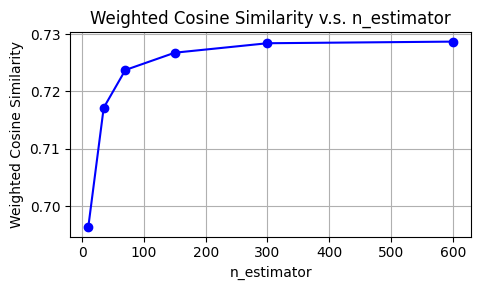

In [136]:
import matplotlib.pyplot as plt

feature_dict = {
    '10': 0.6962897810456837,
    '35': 0.7171412632261647,
    '70': 0.7237203684640613,
    '150': 0.7267410812333778,
    '300': 0.7283914209226714,
    '600': 0.7286738723618706
}

# Extract labels and values for plotting
labels, values = zip(*feature_dict.items())

# Convert labels to integers for plotting
labels = list(map(int, labels))

# Create a line chart
plt.figure(figsize=(5, 3))
plt.plot(labels, values, marker='o', color='blue')
plt.xlabel('n_estimator')
plt.ylabel('Weighted Cosine Similarity')
plt.title('Weighted Cosine Similarity v.s. n_estimator')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## Part 3: Vanilla MLP model

In [14]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [15]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[23:01:45] WARNING: not removing hydrogen atom without neighbors
[23:01:45] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'In', 'Bi', 'N', 'Fe', 'Cl', 'K', 'Re', 'Si', 'Rh', 'Zn', 'Br', 'C', 'Se', 'S', 'Hg', 'Mo', 'F', 'W', 'B', 'Xe', 'Te', 'Sb', 'P', 'I', 'Cd', 'Kr', 'Pb', 'Ni', 'Ar', 'Sn', 'Mn', 'Na', 'As', 'Ge', 'O', 'H', 'Tl', 'Al', 'U', 'Co'}
40


In [16]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]
df.head()


[23:01:55] WARNING: not removing hydrogen atom without neighbors
[23:01:56] WARNING: not removing hydrogen atom without neighbors


features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [17]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)
  new_arr[non_zero_indices] = 1

  return np.concatenate([features, new_arr])

df['features'] = df.apply(add_mz_metadata, axis=1)
df.head() # dimension of features is 377; dimension of spectrum is 300

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
len(df['features'][0])

377

In [18]:
import torch
import torch.nn as nn

# the optimal MLP architecture has 7 hidden layers of 2000 nodes,
# with residual network connections between the layers, using ReLU activation and a dropout rate of 0.25

class MLPRegressor(nn.Module):
    def __init__(self, dropout):
        super(MLPRegressor, self).__init__()

        self.input_layer = nn.Linear(377, 400)

        self.hidden_layer_1 = nn.Linear(400, 400)

        # 400 * 3 + 200 * 4 = 2000 nodes

        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)

        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, input):

        hidden = self.input_layer(input) # 377 -> 400
        hidden = self.dropout(hidden) # 400 -> 400

        for layer in range(3):
          x = hidden # do the redsidual connection
          hidden = self.hidden_layer_1(hidden) # 400 -> 400
          hidden += x
          hidden = self.dropout(hidden) # 400 -> 400

        hidden = self.hidden_layer_2(hidden) # 400 -> 200
        hidden = self.dropout(hidden) # 200 -> 200

        for layer in range(3):
          x = hidden # do the residual connection
          hidden = self.hidden_layer_3(hidden) # 200 -> 200
          hidden += x
          hidden = self.dropout(hidden) # 200 -> 200

        output = self.output_layer(hidden)  # 200 -> 300
        output = self.relu(output) # 300 -> 300

        return output

# 创建你的网络实例
mlpRegressor = MLPRegressor(0.25)
print(mlpRegressor)

MLPRegressor(
  (input_layer): Linear(in_features=377, out_features=400, bias=True)
  (hidden_layer_1): Linear(in_features=400, out_features=400, bias=True)
  (hidden_layer_2): Linear(in_features=400, out_features=200, bias=True)
  (hidden_layer_3): Linear(in_features=200, out_features=200, bias=True)
  (output_layer): Linear(in_features=200, out_features=300, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)


In [19]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WeightedMSELoss, self).__init__()

    def forward(self, outputs, targets, smooth=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

        # I -> m * (I)^(0.5)
        outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
        targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

        # the squared sum of m * (I)^(0.5), add the smooth to prevent nan
        outputsSquaredSum = torch.add(torch.sum(torch.pow(outputs, 2), 1), smooth).unsqueeze(1).to(device)
        targetsSqauredSum = torch.add(torch.sum(torch.pow(targets, 2), 1), smooth).unsqueeze(1).to(device)

        # m * (I)^(0.5) -> m * (I)^(0.5) / squared sum
        outputs = torch.div(outputs, outputsSquaredSum).to(device)
        targets = torch.div(targets, targetsSqauredSum).to(device)

        # take the difference of target and outputs, and get squared sum
        return torch.sum(torch.sum(torch.pow(torch.sub(targets, outputs), 2) , 1)).to(device)

In [20]:
import torch.nn.functional as F

def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to(device)

In [21]:
from sklearn.model_selection import train_test_split, KFold

features = torch.tensor(np.array(df['features'].tolist()))
spectrums = torch.tensor(np.array(df['spectrum'].tolist()))

dataset = TensorDataset(features, spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create a KFold cross-validation object with 3 folds
kf = KFold(n_splits=5, shuffle=True, random_state=8888)

### training of k-fold cross validation (k=5)

In [ ]:
train_indices, val_indices = list(kf.split(train_dataset))[0]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [ ]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1900

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_0.pth'))

  max_sim = 0.6733888983726501
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_best_0.pth')

Streaming output truncated to the last 5000 lines.
======== Epoch 377 / 2400 ========
Training...

======== Epoch 378 / 2400 ========
Training...

======== Epoch 379 / 2400 ========
Training...

======== Epoch 380 / 2400 ========
Training...

======== Epoch 381 / 2400 ========
Training...

======== Epoch 382 / 2400 ========
Training...

======== Epoch 383 / 2400 ========
Training...

======== Epoch 384 / 2400 ========
Training...

======== Epoch 385 / 2400 ========
Training...

======== Epoch 386 / 2400 ========
Training...

======== Epoch 387 / 2400 ========
Training...
update with validation similarity: 0.6382196015781827

======== Epoch 388 / 2400 ========
Training...

======== Epoch 389 / 2400 ========
Training...

======== Epoch 390 / 2400 ========
Training...

======== Epoch 391 / 2400 ========
Training...

======== Epoch 392 / 2400 ========
Training...
update with validation similarity: 0.6384805275334252

======== Epoch 393 / 2400 ========
Training...

======== Epoch 394 / 2400

KeyboardInterrupt: ignored

In [ ]:
train_indices, val_indices = list(kf.split(train_dataset))[1]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [ ]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1900

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_1.pth'))

  max_sim = 0.67803769144747
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_best_1.pth')

Streaming output truncated to the last 5000 lines.

======== Epoch 252 / 1900 ========
Training...

======== Epoch 253 / 1900 ========
Training...

======== Epoch 254 / 1900 ========
Training...

======== Epoch 255 / 1900 ========
Training...

======== Epoch 256 / 1900 ========
Training...

======== Epoch 257 / 1900 ========
Training...

======== Epoch 258 / 1900 ========
Training...

======== Epoch 259 / 1900 ========
Training...

======== Epoch 260 / 1900 ========
Training...

======== Epoch 261 / 1900 ========
Training...

======== Epoch 262 / 1900 ========
Training...

======== Epoch 263 / 1900 ========
Training...

======== Epoch 264 / 1900 ========
Training...

======== Epoch 265 / 1900 ========
Training...

======== Epoch 266 / 1900 ========
Training...

======== Epoch 267 / 1900 ========
Training...

======== Epoch 268 / 1900 ========
Training...

======== Epoch 269 / 1900 ========
Training...
update with validation similarity: 0.6505793862872653

======== Epoch 270 / 1900 ====

In [ ]:
train_indices, val_indices = list(kf.split(train_dataset))[2]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [ ]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1500

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_2.pth'))

  max_sim = 0.6675994777017169
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_best_2.pth')


======== Epoch 1 / 1500 ========
Training...
update with validation similarity: 0.4239671958817376

======== Epoch 2 / 1500 ========
Training...
update with validation similarity: 0.4463125980562634

======== Epoch 3 / 1500 ========
Training...
update with validation similarity: 0.5129877651731173

======== Epoch 4 / 1500 ========
Training...

======== Epoch 5 / 1500 ========
Training...
update with validation similarity: 0.5257370215323236

======== Epoch 6 / 1500 ========
Training...
update with validation similarity: 0.5372867733240128

======== Epoch 7 / 1500 ========
Training...
update with validation similarity: 0.5413714746634165

======== Epoch 8 / 1500 ========
Training...
update with validation similarity: 0.5428878515958786

======== Epoch 9 / 1500 ========
Training...
update with validation similarity: 0.5452172383666039

======== Epoch 10 / 1500 ========
Training...
update with validation similarity: 0.5472814117868742

======== Epoch 11 / 1500 ========
Training...
update

In [ ]:
train_indices, val_indices = list(kf.split(train_dataset))[3]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [ ]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1500

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_3.pth'))

  max_sim = 0.6638689355717765
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_best_3.pth')


======== Epoch 1 / 1500 ========
Training...
update with validation similarity: 0.42340829968452454

======== Epoch 2 / 1500 ========
Training...
update with validation similarity: 0.43895943545632893

======== Epoch 3 / 1500 ========
Training...
update with validation similarity: 0.5049819308850501

======== Epoch 4 / 1500 ========
Training...
update with validation similarity: 0.5153922993275855

======== Epoch 5 / 1500 ========
Training...
update with validation similarity: 0.5241158273484972

======== Epoch 6 / 1500 ========
Training...
update with validation similarity: 0.534700784418318

======== Epoch 7 / 1500 ========
Training...
update with validation similarity: 0.5374982009331385

======== Epoch 8 / 1500 ========
Training...
update with validation similarity: 0.5410785559150908

======== Epoch 9 / 1500 ========
Training...
update with validation similarity: 0.5426788719164001

======== Epoch 10 / 1500 ========
Training...
update with validation similarity: 0.543840979536374

In [12]:
train_indices, val_indices = list(kf.split(train_dataset))[4]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [13]:
from sqlalchemy import True_
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1200

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_4.pth'))

  max_sim = 0.663315259748035
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_best_4.pth')


======== Epoch 1 / 1200 ========
Training...
update with validation similarity: 0.4262596269448598

======== Epoch 2 / 1200 ========
Training...
update with validation similarity: 0.4543665109409226

======== Epoch 3 / 1200 ========
Training...
update with validation similarity: 0.525542048116525

======== Epoch 4 / 1200 ========
Training...
update with validation similarity: 0.5329881178008186

======== Epoch 5 / 1200 ========
Training...
update with validation similarity: 0.542070832517412

======== Epoch 6 / 1200 ========
Training...
update with validation similarity: 0.5456613484356139

======== Epoch 7 / 1200 ========
Training...
update with validation similarity: 0.5478660373224152

======== Epoch 8 / 1200 ========
Training...
update with validation similarity: 0.550267583794064

======== Epoch 9 / 1200 ========
Training...
update with validation similarity: 0.5510377883911133

======== Epoch 10 / 1200 ========
Training...
update with validation similarity: 0.5527282373772727

=

### test the k-fold cross validation model on test set (average)

In [23]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [25]:
backwardMLP_1 = MLPRegressor(0.25)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_0.pth'))
# 0.6733888983726501

backwardMLP_2 = MLPRegressor(0.25)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_1.pth'))
# 0.67803769144747

backwardMLP_3 = MLPRegressor(0.25)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_2.pth'))
# 0.6675994777017169

backwardMLP_4 = MLPRegressor(0.25)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_3.pth'))
# 0.6638689355717765

backwardMLP_5 = MLPRegressor(0.25)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_4.pth'))
# 0.663315259748035


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input)
      output_2 = backwardMLP_2(b_input)
      output_3 = backwardMLP_3(b_input)
      output_4 = backwardMLP_4(b_input)
      output_5 = backwardMLP_5(b_input)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      batch_sim = WeightedSimlarity(output, b_labels)
      total_test_sim += torch.mean(batch_sim).item()

      max_test_step += 1

print(
    f'''Test similarity: {total_test_sim / max_test_step}''') # 0.6461809423234728

Test similarity: 0.6461809423234728


## Part 4: CNN MLP model

In [62]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [63]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[23:07:30] WARNING: not removing hydrogen atom without neighbors
[23:07:31] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'In', 'Bi', 'N', 'Fe', 'Cl', 'K', 'Re', 'Si', 'Rh', 'Zn', 'Br', 'C', 'Se', 'S', 'Hg', 'Mo', 'F', 'W', 'B', 'Xe', 'Te', 'Sb', 'P', 'I', 'Cd', 'Kr', 'Pb', 'Ni', 'Ar', 'Sn', 'Mn', 'Na', 'As', 'Ge', 'O', 'H', 'Tl', 'Al', 'U', 'Co'}
40


In [64]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]
df.head()

[23:07:41] WARNING: not removing hydrogen atom without neighbors
[23:07:43] WARNING: not removing hydrogen atom without neighbors


features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [65]:
# do the normalisation on spectrum data

def normalisation(spectrum):
  spectrum = np.array(spectrum)

  # Compute the sum of all non-zero elements
  sum_non_zero = np.sum(spectrum[spectrum != 0])

  # Normalize the vector by dividing each non-zero element by the sum
  normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)

  return normalized_spectrum


df['spectrum'] = df['spectrum'].apply(lambda x: normalisation(x))
df.head()

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [66]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)
  new_arr[non_zero_indices] = 1

  return new_arr

df['positions'] = df.apply(add_mz_metadata, axis=1)
df.head() # dimension of features is 377; dimension of spectrum is 300

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           positions  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [ ]:
len(df['positions'][0])

300

In [ ]:
len(df['features'][0])

77

In [67]:
import torch
import torch.nn as nn

class CNN_MLP(nn.Module):
    def __init__(self, num_layers, dropout=0.5):
        super(CNN_MLP, self).__init__()

        layers = []
        in_channels = 1
        out_channels = 64  # Number of channels in the first convolutional layer

        # Add convolutional layers
        for i in range(num_layers):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            in_channels = out_channels
            out_channels *= 2  # Double the number of channels in each layer

        self.conv_layers = nn.Sequential(*layers)

        # Calculate the input size for the fully connected layer
        self.fc_layer = nn.Linear(in_channels*77+300, 200)

        # MLP layers
        self.input_layer = nn.Linear(200, 400)
        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, positions):  # [32, 77], [32, 300]
        x = x.unsqueeze(1) # [32, 1, 77]

        cnn_out = self.conv_layers(x) # [32, 128, 77]
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # [32, 9856]

        cnn_out = torch.cat((cnn_out, positions), dim=1) # [32, 10156]
        cnn_out = self.fc_layer(cnn_out) # [32, 200]

        # MLP forward pass
        hidden = self.input_layer(cnn_out) # [32, 400]
        hidden = self.dropout(hidden) # [32, 400]

        for _ in range(3):
            x = hidden
            hidden = self.hidden_layer_1(hidden) # [32, 400]
            hidden += x
            hidden = self.dropout(hidden) # [32, 400]

        hidden = self.hidden_layer_2(hidden) # [32, 200]
        hidden = self.dropout(hidden)  # [32, 200]

        for _ in range(3):
            x = hidden
            hidden = self.hidden_layer_3(hidden) # [32, 200]
            hidden += x
            hidden = self.dropout(hidden) # [32, 200]

        output = self.output_layer(hidden) # [32, 300]
        output = self.relu(output) # [32, 300]

        return output # [32, 300]


In [40]:
# Create an instance of the CNN_MLP model
model = CNN_MLP(num_layers=3, dropout=0.5)

# Generate random input data
features = torch.rand(32, 77)
positions = torch.rand(32, 300)
# Perform a forward pass
output = model(features, positions)

# Print the shape of the output tensor
print("Output Shape:", output.shape)


Output Shape: torch.Size([32, 300])


In [68]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WeightedMSELoss, self).__init__()

    def forward(self, outputs, targets, smooth=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

        # I -> m * (I)^(0.5)
        outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
        targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

        # the squared sum of m * (I)^(0.5), add the smooth to prevent nan
        outputsSquaredSum = torch.add(torch.sum(torch.pow(outputs, 2), 1), smooth).unsqueeze(1).to(device)
        targetsSqauredSum = torch.add(torch.sum(torch.pow(targets, 2), 1), smooth).unsqueeze(1).to(device)

        # m * (I)^(0.5) -> m * (I)^(0.5) / squared sum
        outputs = torch.div(outputs, outputsSquaredSum).to(device)
        targets = torch.div(targets, targetsSqauredSum).to(device)

        # take the difference of target and outputs, and get squared sum
        return torch.sum(torch.sum(torch.pow(torch.sub(targets, outputs), 2) , 1)).to(device)

In [69]:
import torch.nn.functional as F

def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to(device)

In [70]:
from sklearn.model_selection import train_test_split, KFold

features = torch.tensor(np.array(df['features'].tolist()))
positions = torch.tensor(np.array(df['positions'].tolist()))
spectrums = torch.tensor(np.array(df['spectrum'].tolist()))

dataset = TensorDataset(features, positions, spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create a KFold cross-validation object with 3 folds
kf = KFold(n_splits=5, shuffle=True, random_state=8888)

### 1-layer CNN

#### training

In [71]:
train_indices, val_indices = list(kf.split(train_dataset))[0]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [73]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 100

# train type
from_strach = False

num_layers = 1
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_0.pth'))

  max_sim = 0.725552499294281
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_0.pth')

load the checkpoints

======== Epoch 1 / 100 ========
Training...
update with validation similarity: 0.7152373592058817

======== Epoch 2 / 100 ========
Training...

======== Epoch 3 / 100 ========
Training...

======== Epoch 4 / 100 ========
Training...

======== Epoch 5 / 100 ========
Training...
update with validation similarity: 0.7203181236982346

======== Epoch 6 / 100 ========
Training...

======== Epoch 7 / 100 ========
Training...

======== Epoch 8 / 100 ========
Training...

======== Epoch 9 / 100 ========
Training...

======== Epoch 10 / 100 ========
Training...

======== Epoch 11 / 100 ========
Training...

======== Epoch 12 / 100 ========
Training...

======== Epoch 13 / 100 ========
Training...

======== Epoch 14 / 100 ========
Training...
update with validation similarity: 0.7203758060932159

======== Epoch 15 / 100 ========
Training...

======== Epoch 16 / 100 ========
Training...

======== Epoch 17 / 100 ========
Training...

======== Epoch 18 / 100 ========
Training..

In [74]:
train_indices, val_indices = list(kf.split(train_dataset))[1]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [76]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 100

# train type
from_strach = False

num_layers = 1
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_1.pth'))

  max_sim = 0.7304001732005013
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_1.pth')

load the checkpoints

======== Epoch 1 / 100 ========
Training...
update with validation similarity: 0.6950103408760495

======== Epoch 2 / 100 ========
Training...
update with validation similarity: 0.700644893778695

======== Epoch 3 / 100 ========
Training...
update with validation similarity: 0.7101060102383295

======== Epoch 4 / 100 ========
Training...
update with validation similarity: 0.7121431993113624

======== Epoch 5 / 100 ========
Training...
update with validation similarity: 0.7140491753816605

======== Epoch 6 / 100 ========
Training...
update with validation similarity: 0.7161896079778671

======== Epoch 7 / 100 ========
Training...

======== Epoch 8 / 100 ========
Training...

======== Epoch 9 / 100 ========
Training...

======== Epoch 10 / 100 ========
Training...

======== Epoch 11 / 100 ========
Training...
update with validation similarity: 0.7182544536060758

======== Epoch 12 / 100 ========
Training...
update with validation similarity: 0.7201300114393234

====

In [77]:
train_indices, val_indices = list(kf.split(train_dataset))[2]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [78]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 100

# train type
from_strach = False

num_layers = 1
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_2.pth'))

  max_sim = 0.7247027241521411
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_2.pth')

load the checkpoints

======== Epoch 1 / 100 ========
Training...
update with validation similarity: 0.6931711783011755

======== Epoch 2 / 100 ========
Training...
update with validation similarity: 0.7042630198929045

======== Epoch 3 / 100 ========
Training...
update with validation similarity: 0.7043424844741821

======== Epoch 4 / 100 ========
Training...
update with validation similarity: 0.7073793477482266

======== Epoch 5 / 100 ========
Training...
update with validation similarity: 0.7120015886094835

======== Epoch 6 / 100 ========
Training...
update with validation similarity: 0.7122617661952972

======== Epoch 7 / 100 ========
Training...
update with validation similarity: 0.7139776332510842

======== Epoch 8 / 100 ========
Training...

======== Epoch 9 / 100 ========
Training...
update with validation similarity: 0.7144400576750437

======== Epoch 10 / 100 ========
Training...

======== Epoch 11 / 100 ========
Training...

======== Epoch 12 / 100 ========
Training...
upda

In [79]:
train_indices, val_indices = list(kf.split(train_dataset))[3]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [80]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 100

# train type
from_strach = False

num_layers = 1
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_3.pth'))

  max_sim = 0.7273737688859304
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_3.pth')

load the checkpoints

======== Epoch 1 / 100 ========
Training...
update with validation similarity: 0.6916188779804442

======== Epoch 2 / 100 ========
Training...
update with validation similarity: 0.7097133182817035

======== Epoch 3 / 100 ========
Training...
update with validation similarity: 0.7124412175681856

======== Epoch 4 / 100 ========
Training...

======== Epoch 5 / 100 ========
Training...

======== Epoch 6 / 100 ========
Training...
update with validation similarity: 0.7153929769992828

======== Epoch 7 / 100 ========
Training...

======== Epoch 8 / 100 ========
Training...

======== Epoch 9 / 100 ========
Training...

======== Epoch 10 / 100 ========
Training...

======== Epoch 11 / 100 ========
Training...

======== Epoch 12 / 100 ========
Training...
update with validation similarity: 0.7189385510153241

======== Epoch 13 / 100 ========
Training...
update with validation similarity: 0.719289630651474

======== Epoch 14 / 100 ========
Training...

======== Epoch 15 / 

In [81]:
train_indices, val_indices = list(kf.split(train_dataset))[4]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [83]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 100

# train type
from_strach = False

num_layers = 1
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_4.pth'))

  max_sim = 0.7269948770602545
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_4.pth')

load the checkpoints

======== Epoch 1 / 100 ========
Training...
update with validation similarity: 0.7041546470589108

======== Epoch 2 / 100 ========
Training...

======== Epoch 3 / 100 ========
Training...

======== Epoch 4 / 100 ========
Training...
update with validation similarity: 0.7087587498956256

======== Epoch 5 / 100 ========
Training...

======== Epoch 6 / 100 ========
Training...

======== Epoch 7 / 100 ========
Training...
update with validation similarity: 0.7140965412060419

======== Epoch 8 / 100 ========
Training...

======== Epoch 9 / 100 ========
Training...

======== Epoch 10 / 100 ========
Training...

======== Epoch 11 / 100 ========
Training...

======== Epoch 12 / 100 ========
Training...
update with validation similarity: 0.7160145458247926

======== Epoch 13 / 100 ========
Training...

======== Epoch 14 / 100 ========
Training...
update with validation similarity: 0.7171347886323929

======== Epoch 15 / 100 ========
Training...

======== Epoch 16 / 100 ===

#### evaluation

In [84]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [85]:
backwardMLP_1 = CNN_MLP(1, 0.15)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_0.pth'))
# 0.725552499294281

backwardMLP_2 = CNN_MLP(1, 0.15)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_1.pth'))
# 0.7304001732005013

backwardMLP_3 = CNN_MLP(1, 0.15)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_2.pth'))
# 0.7247027241521411

backwardMLP_4 = CNN_MLP(1, 0.15)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_3.pth'))
# 0.7273737688859304

backwardMLP_5 = CNN_MLP(1, 0.15)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_1_best_4.pth'))
# 0.7269948770602545


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input, b_positions)
      output_2 = backwardMLP_2(b_input, b_positions)
      output_3 = backwardMLP_3(b_input, b_positions)
      output_4 = backwardMLP_4(b_input, b_positions)
      output_5 = backwardMLP_5(b_input, b_positions)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      batch_sim = WeightedSimlarity(output, b_labels)
      total_test_sim += torch.mean(batch_sim).item()

      max_test_step += 1

print(
    f'''Test similarity: {total_test_sim / max_test_step}''') # 0.7396331244044834

Test similarity: 0.7396331244044834


### 2-layer CNN

#### training

In [94]:
train_indices, val_indices = list(kf.split(train_dataset))[0]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [95]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 700

# train type
from_strach = False

num_layers = 2
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_0.pth'))

  max_sim = 0.7564648919635348
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_0.pth')


======== Epoch 1 / 700 ========
Training...
update with validation similarity: 0.4349154225654072

======== Epoch 2 / 700 ========
Training...
update with validation similarity: 0.48429334577586913

======== Epoch 3 / 700 ========
Training...
update with validation similarity: 0.48443001839849686

======== Epoch 4 / 700 ========
Training...
update with validation similarity: 0.4912559986114502

======== Epoch 5 / 700 ========
Training...
update with validation similarity: 0.505538184609678

======== Epoch 6 / 700 ========
Training...

======== Epoch 7 / 700 ========
Training...
update with validation similarity: 0.5135912373661995

======== Epoch 8 / 700 ========
Training...
update with validation similarity: 0.5177840010987388

======== Epoch 9 / 700 ========
Training...

======== Epoch 10 / 700 ========
Training...
update with validation similarity: 0.5326345355974303

======== Epoch 11 / 700 ========
Training...

======== Epoch 12 / 700 ========
Training...
update with validation s

In [96]:
train_indices, val_indices = list(kf.split(train_dataset))[1]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [97]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 700

# train type
from_strach = False

num_layers = 2
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_1.pth'))

  max_sim = 0.7580894231796265
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_1.pth')


======== Epoch 1 / 700 ========
Training...
update with validation similarity: 0.4483092518316375

======== Epoch 2 / 700 ========
Training...
update with validation similarity: 0.48492782645755345

======== Epoch 3 / 700 ========
Training...
update with validation similarity: 0.49338645074102616

======== Epoch 4 / 700 ========
Training...
update with validation similarity: 0.5052251451545291

======== Epoch 5 / 700 ========
Training...
update with validation similarity: 0.5139770176675584

======== Epoch 6 / 700 ========
Training...
update with validation similarity: 0.5271729015641742

======== Epoch 7 / 700 ========
Training...

======== Epoch 8 / 700 ========
Training...

======== Epoch 9 / 700 ========
Training...

======== Epoch 10 / 700 ========
Training...
update with validation similarity: 0.535233661532402

======== Epoch 11 / 700 ========
Training...
update with validation similarity: 0.5504796430468559

======== Epoch 12 / 700 ========
Training...

======== Epoch 13 / 700

In [98]:
train_indices, val_indices = list(kf.split(train_dataset))[2]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [99]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 700

# train type
from_strach = False

num_layers = 2
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_2.pth'))

  max_sim = 0.7575204173723856
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_2.pth')


======== Epoch 1 / 700 ========
Training...
update with validation similarity: 0.44247730324665707

======== Epoch 2 / 700 ========
Training...
update with validation similarity: 0.48453664696878856

======== Epoch 3 / 700 ========
Training...
update with validation similarity: 0.4929700212346183

======== Epoch 4 / 700 ========
Training...
update with validation similarity: 0.4963509357637829

======== Epoch 5 / 700 ========
Training...
update with validation similarity: 0.499640258649985

======== Epoch 6 / 700 ========
Training...
update with validation similarity: 0.519040601948897

======== Epoch 7 / 700 ========
Training...
update with validation similarity: 0.5221263012952275

======== Epoch 8 / 700 ========
Training...
update with validation similarity: 0.523828874859545

======== Epoch 9 / 700 ========
Training...
update with validation similarity: 0.5384052462048001

======== Epoch 10 / 700 ========
Training...
update with validation similarity: 0.5389369378487269

======== 

In [100]:
train_indices, val_indices = list(kf.split(train_dataset))[3]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [101]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 700

# train type
from_strach = False

num_layers = 2
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_3.pth'))

  max_sim = 0.7555318259530597
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_3.pth')


======== Epoch 1 / 700 ========
Training...
update with validation similarity: 0.45203667961888844

======== Epoch 2 / 700 ========
Training...
update with validation similarity: 0.4740500185224745

======== Epoch 3 / 700 ========
Training...
update with validation similarity: 0.4863291440738572

======== Epoch 4 / 700 ========
Training...

======== Epoch 5 / 700 ========
Training...
update with validation similarity: 0.5088561367657449

======== Epoch 6 / 700 ========
Training...

======== Epoch 7 / 700 ========
Training...

======== Epoch 8 / 700 ========
Training...
update with validation similarity: 0.5172333618005117

======== Epoch 9 / 700 ========
Training...
update with validation similarity: 0.5191655663980378

======== Epoch 10 / 700 ========
Training...

======== Epoch 11 / 700 ========
Training...
update with validation similarity: 0.5254557314846251

======== Epoch 12 / 700 ========
Training...
update with validation similarity: 0.5380856783853637

======== Epoch 13 / 700

In [102]:
train_indices, val_indices = list(kf.split(train_dataset))[4]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [103]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 700

# train type
from_strach = False

num_layers = 2
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_4.pth'))

  max_sim = 0.7572523338927163
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_4.pth')


======== Epoch 1 / 700 ========
Training...
update with validation similarity: 0.4322599569956462

======== Epoch 2 / 700 ========
Training...
update with validation similarity: 0.46279360188378227

======== Epoch 3 / 700 ========
Training...
update with validation similarity: 0.4897712709175216

======== Epoch 4 / 700 ========
Training...
update with validation similarity: 0.4903506173027886

======== Epoch 5 / 700 ========
Training...
update with validation similarity: 0.5036217106713189

======== Epoch 6 / 700 ========
Training...

======== Epoch 7 / 700 ========
Training...
update with validation similarity: 0.5130972680118349

======== Epoch 8 / 700 ========
Training...

======== Epoch 9 / 700 ========
Training...
update with validation similarity: 0.5163651920027204

======== Epoch 10 / 700 ========
Training...
update with validation similarity: 0.5356568222244581

======== Epoch 11 / 700 ========
Training...

======== Epoch 12 / 700 ========
Training...
update with validation s

#### evaluation

In [47]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [48]:
backwardMLP_1 = CNN_MLP(2, 0.15)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_0.pth'))
# 0.7564648919635348

backwardMLP_2 = CNN_MLP(2, 0.15)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_1.pth'))
# 0.7580894231796265

backwardMLP_3 = CNN_MLP(2, 0.15)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_2.pth'))
# 0.7575204173723856

backwardMLP_4 = CNN_MLP(2, 0.15)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_3.pth'))
# 0.7555318259530597

backwardMLP_5 = CNN_MLP(2, 0.15)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_2_best_4.pth'))
# 0.7572523338927163


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input, b_positions)
      output_2 = backwardMLP_2(b_input, b_positions)
      output_3 = backwardMLP_3(b_input, b_positions)
      output_4 = backwardMLP_4(b_input, b_positions)
      output_5 = backwardMLP_5(b_input, b_positions)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      batch_sim = WeightedSimlarity(output, b_labels)
      total_test_sim += torch.mean(batch_sim).item()

      max_test_step += 1

print(
    f'''Test similarity: {total_test_sim / max_test_step}''') # 0.732778153154585

Test similarity: 0.732778153154585


### 3-layer CNN

#### training

In [20]:
train_indices, val_indices = list(kf.split(train_dataset))[0]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [22]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 300

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_0.pth'))

  max_sim = 0.7561047706339095
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_0.pth')

load the checkpoints

======== Epoch 1 / 300 ========
Training...
update with validation similarity: 0.7509321719408035

======== Epoch 2 / 300 ========
Training...
update with validation similarity: 0.7527089466651281

======== Epoch 3 / 300 ========
Training...
update with validation similarity: 0.753574831618203

======== Epoch 4 / 300 ========
Training...

======== Epoch 5 / 300 ========
Training...
update with validation similarity: 0.7555157989263535

======== Epoch 6 / 300 ========
Training...

======== Epoch 7 / 300 ========
Training...

======== Epoch 8 / 300 ========
Training...

======== Epoch 9 / 300 ========
Training...

======== Epoch 10 / 300 ========
Training...

======== Epoch 11 / 300 ========
Training...

======== Epoch 12 / 300 ========
Training...

======== Epoch 13 / 300 ========
Training...

======== Epoch 14 / 300 ========
Training...

======== Epoch 15 / 300 ========
Training...

======== Epoch 16 / 300 ========
Training...

======== Epoch 17 / 300 ========
Tra

KeyboardInterrupt: ignored

In [23]:
train_indices, val_indices = list(kf.split(train_dataset))[1]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [24]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 80

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_1.pth'))

  max_sim = 0.7569857918553882
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_1.pth')

load the checkpoints

======== Epoch 1 / 80 ========
Training...

======== Epoch 2 / 80 ========
Training...
update with validation similarity: 0.7548761798275841

======== Epoch 3 / 80 ========
Training...

======== Epoch 4 / 80 ========
Training...

======== Epoch 5 / 80 ========
Training...

======== Epoch 6 / 80 ========
Training...
update with validation similarity: 0.7551243686013751

======== Epoch 7 / 80 ========
Training...
update with validation similarity: 0.7567308909363217

======== Epoch 8 / 80 ========
Training...

======== Epoch 9 / 80 ========
Training...

======== Epoch 10 / 80 ========
Training...

======== Epoch 11 / 80 ========
Training...
update with validation similarity: 0.7567988468541039

======== Epoch 12 / 80 ========
Training...

======== Epoch 13 / 80 ========
Training...

======== Epoch 14 / 80 ========
Training...

======== Epoch 15 / 80 ========
Training...

======== Epoch 16 / 80 ========
Training...

======== Epoch 17 / 80 ========
Training...

======

In [25]:
train_indices, val_indices = list(kf.split(train_dataset))[2]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [26]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 60

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_2.pth'))

  max_sim = 0.7577419281005859
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_2.pth')

load the checkpoints

======== Epoch 1 / 60 ========
Training...

======== Epoch 2 / 60 ========
Training...

======== Epoch 3 / 60 ========
Training...

======== Epoch 4 / 60 ========
Training...
update with validation similarity: 0.7560538185967339

======== Epoch 5 / 60 ========
Training...
update with validation similarity: 0.7569163905249702

======== Epoch 6 / 60 ========
Training...

======== Epoch 7 / 60 ========
Training...

======== Epoch 8 / 60 ========
Training...

======== Epoch 9 / 60 ========
Training...

======== Epoch 10 / 60 ========
Training...

======== Epoch 11 / 60 ========
Training...

======== Epoch 12 / 60 ========
Training...

======== Epoch 13 / 60 ========
Training...
update with validation similarity: 0.7570692565706041

======== Epoch 14 / 60 ========
Training...

======== Epoch 15 / 60 ========
Training...

======== Epoch 16 / 60 ========
Training...

======== Epoch 17 / 60 ========
Training...

======== Epoch 18 / 60 ========
Training...

======== Epoch 

In [27]:
train_indices, val_indices = list(kf.split(train_dataset))[3]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [28]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 60

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_3.pth'))

  max_sim = 0.7555648105012046
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_3.pth')

load the checkpoints

======== Epoch 1 / 60 ========
Training...

======== Epoch 2 / 60 ========
Training...

======== Epoch 3 / 60 ========
Training...
update with validation similarity: 0.7534769773483276

======== Epoch 4 / 60 ========
Training...

======== Epoch 5 / 60 ========
Training...

======== Epoch 6 / 60 ========
Training...
update with validation similarity: 0.7539193348752128

======== Epoch 7 / 60 ========
Training...

======== Epoch 8 / 60 ========
Training...

======== Epoch 9 / 60 ========
Training...

======== Epoch 10 / 60 ========
Training...

======== Epoch 11 / 60 ========
Training...

======== Epoch 12 / 60 ========
Training...

======== Epoch 13 / 60 ========
Training...
update with validation similarity: 0.7550733801391389

======== Epoch 14 / 60 ========
Training...

======== Epoch 15 / 60 ========
Training...

======== Epoch 16 / 60 ========
Training...

======== Epoch 17 / 60 ========
Training...
update with validation similarity: 0.7553391075796552

======

In [29]:
train_indices, val_indices = list(kf.split(train_dataset))[4]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [30]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 60

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.15)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_4.pth'))

  max_sim = 0.7579118460416794
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_4.pth')

load the checkpoints

======== Epoch 1 / 60 ========
Training...

======== Epoch 2 / 60 ========
Training...

======== Epoch 3 / 60 ========
Training...
update with validation similarity: 0.7563458797004488

======== Epoch 4 / 60 ========
Training...

======== Epoch 5 / 60 ========
Training...

======== Epoch 6 / 60 ========
Training...
update with validation similarity: 0.7567526019281812

======== Epoch 7 / 60 ========
Training...

======== Epoch 8 / 60 ========
Training...

======== Epoch 9 / 60 ========
Training...

======== Epoch 10 / 60 ========
Training...
update with validation similarity: 0.7578478025065528

======== Epoch 11 / 60 ========
Training...

======== Epoch 12 / 60 ========
Training...

======== Epoch 13 / 60 ========
Training...

======== Epoch 14 / 60 ========
Training...

======== Epoch 15 / 60 ========
Training...

======== Epoch 16 / 60 ========
Training...

======== Epoch 17 / 60 ========
Training...

======== Epoch 18 / 60 ========
Training...

======== Epoch 

#### evaluation

In [49]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [50]:
backwardMLP_1 = CNN_MLP(3, 0.15)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_0.pth'))
# 0.7537260370122062

backwardMLP_2 = CNN_MLP(3, 0.15)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_1.pth'))
# 0.7545139574342303

backwardMLP_3 = CNN_MLP(3, 0.15)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_2.pth'))
# 0.7548902382453283

backwardMLP_4 = CNN_MLP(3, 0.15)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_3.pth'))
# 0.7530291179815928

backwardMLP_5 = CNN_MLP(3, 0.15)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_4.pth'))
# 0.7553089906771978


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input, b_positions)
      output_2 = backwardMLP_2(b_input, b_positions)
      output_3 = backwardMLP_3(b_input, b_positions)
      output_4 = backwardMLP_4(b_input, b_positions)
      output_5 = backwardMLP_5(b_input, b_positions)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      batch_sim = WeightedSimlarity(output, b_labels)
      total_test_sim += torch.mean(batch_sim).item()

      max_test_step += 1

print(
    f'''Test similarity: {total_test_sim / max_test_step}''') # 0.757574999332428

Test similarity: 0.757574999332428


### visualise the optimal num of layer

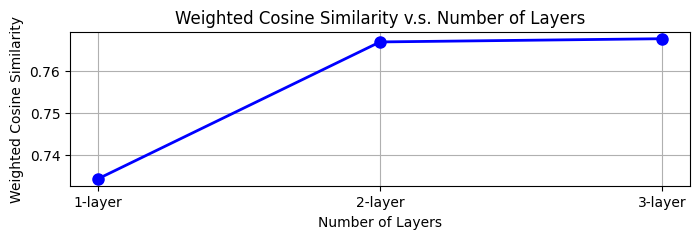

In [135]:
import matplotlib.pyplot as plt

feature_dict = {
    '1-layer': 0.7344755053520202,
    '2-layer': 0.7667962537871467,
    '3-layer': 0.7675550871425205
}


# Extract labels and values for plotting
labels, values = zip(*feature_dict.items())

# Create a line chart
plt.figure(figsize=(8, 2))
plt.plot(labels, values, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)

plt.xlabel('Number of Layers')
plt.ylabel('Weighted Cosine Similarity')
plt.title('Weighted Cosine Similarity v.s. Number of Layers')
plt.grid(True)

# Show the plot
plt.show()


## Part 5: Feature Importace Evaluation

In [49]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [50]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[17:12:34] WARNING: not removing hydrogen atom without neighbors
[17:12:34] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'U', 'Br', 'O', 'H', 'Na', 'C', 'Bi', 'Zn', 'Mo', 'Ni', 'Re', 'Xe', 'W', 'Al', 'B', 'As', 'Ge', 'Kr', 'Mn', 'F', 'K', 'P', 'Sn', 'Se', 'Rh', 'I', 'Pb', 'Ar', 'In', 'Cd', 'Cl', 'S', 'Hg', 'Fe', 'Co', 'N', 'Sb', 'Te', 'Tl', 'Si'}
40


In [51]:
# do the normalisation on spectrum data

def normalisation(spectrum):
  spectrum = np.array(spectrum)

  # Compute the sum of all non-zero elements
  sum_non_zero = np.sum(spectrum[spectrum != 0])

  # Normalize the vector by dividing each non-zero element by the sum
  normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)

  return normalized_spectrum


df['spectrum'] = df['spectrum'].apply(lambda x: normalisation(x))
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [52]:
def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to("cpu").numpy()

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

### single molecule_mass

In [109]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  concatenated_vector = np.zeros(1)

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  concatenated_vector = [molecular_mass]

  return concatenated_vector # 77-length vector

df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:31:57] WARNING: not removing hydrogen atom without neighbors
[18:31:58] WARNING: not removing hydrogen atom without neighbors


In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.48983827329483753


Average Weighted Cosine Similarity: 0.48983827329483753


### single molecule_atomNum

In [111]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  concatenated_vector = np.zeros(1)

  # add some global information about given molecule
  num_atoms = mol.GetNumAtoms()
  concatenated_vector = [num_atoms]

  return concatenated_vector # 77-length vector

df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:32:53] WARNING: not removing hydrogen atom without neighbors
[18:32:53] WARNING: not removing hydrogen atom without neighbors


In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.534173515095229


Average Weighted Cosine Similarity: 0.534173515095229


### single molecule_bondsNum

In [113]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  concatenated_vector = np.zeros(1)

  # add some global information about given molecule
  num_bonds = mol.GetNumBonds()
  concatenated_vector = [num_bonds]

  return concatenated_vector # 77-length vector

df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:33:14] WARNING: not removing hydrogen atom without neighbors
[18:33:14] WARNING: not removing hydrogen atom without neighbors


In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5345888017442457


Average Weighted Cosine Similarity: 0.5345888017442457


### single molecule_ringsNum

In [115]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  concatenated_vector = np.zeros(1)

  # add some global information about given molecule
  num_rings = len(Chem.GetSymmSSSR(mol))
  concatenated_vector = [num_rings]

  return concatenated_vector # 77-length vector

df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:34:44] WARNING: not removing hydrogen atom without neighbors
[18:34:45] WARNING: not removing hydrogen atom without neighbors


In [116]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5417515181119142


Average Weighted Cosine Similarity: 0.5417515181119142


### single m/z position

In [118]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  concatenated_vector = []

  return concatenated_vector # 77-length vector

df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:36:58] WARNING: not removing hydrogen atom without neighbors
[18:36:58] WARNING: not removing hydrogen atom without neighbors


In [119]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)
  new_arr[non_zero_indices] = 1

  return np.concatenate([features, new_arr])

df['features'] = df.apply(add_mz_metadata, axis=1)

In [120]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.7478837371715238


Average Weighted Cosine Similarity: 0.7478837371715238


### single atom_symbol

In [123]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(40)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    concatenated_atom_vector = np.concatenate([atom_symbol_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    concatenated_atom_vector += np.concatenate([atom_symbol_vector])

    concatenated_vector += np.concatenate([concatenated_atom_vector])


  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:46:52] WARNING: not removing hydrogen atom without neighbors
[18:46:53] WARNING: not removing hydrogen atom without neighbors


In [124]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5129917036613328


Average Weighted Cosine Similarity: 0.5129917036613328


### single atom_degree

In [126]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    concatenated_atom_vector = np.concatenate([degree_vector])

    # Create one-hot encoded vectors for atom2
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    concatenated_atom_vector += np.concatenate([degree_vector])

    concatenated_vector += np.concatenate([concatenated_atom_vector])


  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:50:00] WARNING: not removing hydrogen atom without neighbors
[18:50:00] WARNING: not removing hydrogen atom without neighbors


In [127]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5341355812722585


Average Weighted Cosine Similarity: 0.5341355812722585


### single atom_valence

In [129]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    concatenated_atom_vector = np.concatenate([valence_vector])

    # Create one-hot encoded vectors for atom2
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    concatenated_atom_vector += np.concatenate([valence_vector])

    concatenated_vector += np.concatenate([concatenated_atom_vector])


  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:52:50] WARNING: not removing hydrogen atom without neighbors
[18:52:50] WARNING: not removing hydrogen atom without neighbors


In [130]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5240342551340396


Average Weighted Cosine Similarity: 0.5240342551340396


### single atom_hybridization

In [131]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    concatenated_atom_vector = np.concatenate([hybridization_vector])

    # Create one-hot encoded vectors for atom2
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    concatenated_atom_vector += np.concatenate([hybridization_vector])

    concatenated_vector += np.concatenate([concatenated_atom_vector])


  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:55:11] WARNING: not removing hydrogen atom without neighbors
[18:55:11] WARNING: not removing hydrogen atom without neighbors


In [132]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5148071556730031


Average Weighted Cosine Similarity: 0.5148071556730031


### single atom_aromaticity

In [133]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(1)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector
    concatenated_atom_vector = np.concatenate([aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector
    concatenated_atom_vector += np.concatenate([aromaticity_vector])

    concatenated_vector += np.concatenate([concatenated_atom_vector])


  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[18:57:45] WARNING: not removing hydrogen atom without neighbors
[18:57:46] WARNING: not removing hydrogen atom without neighbors


In [134]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.548105662040714


Average Weighted Cosine Similarity: 0.548105662040714


### single bond_type

In [136]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(5)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:

    # Bond type
    bond_type = bond.GetBondType().name

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])

    concatenated_bond_vector = np.concatenate([bond_type_vector])
    concatenated_vector += np.concatenate([concatenated_bond_vector])

  return concatenated_vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[19:00:29] WARNING: not removing hydrogen atom without neighbors
[19:00:29] WARNING: not removing hydrogen atom without neighbors


In [137]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5351309356447911


Average Weighted Cosine Similarity: 0.5351309356447911


### single bond_conjugation

In [138]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(1)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    conjugation_vector = np.array([is_conjugated])

    concatenated_bond_vector = np.concatenate([conjugation_vector ])
    concatenated_vector += np.concatenate([concatenated_bond_vector])

  return concatenated_vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[19:03:12] WARNING: not removing hydrogen atom without neighbors
[19:03:12] WARNING: not removing hydrogen atom without neighbors


In [139]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.546149375907598


Average Weighted Cosine Similarity: 0.546149375907598


### single bond_inRing

In [140]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(1)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    in_ring_vector = np.array([is_in_ring])

    concatenated_bond_vector = np.concatenate([in_ring_vector])
    concatenated_vector += np.concatenate([concatenated_bond_vector])

  return concatenated_vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[19:05:07] WARNING: not removing hydrogen atom without neighbors
[19:05:07] WARNING: not removing hydrogen atom without neighbors


In [141]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5459589366394426


Average Weighted Cosine Similarity: 0.5459589366394426


### single bond_chirality

In [142]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(4)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:

    chirality = bond.GetStereo()

    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([chirality_vector])
    concatenated_vector += np.concatenate([concatenated_bond_vector])

  return concatenated_vector


df['features'] = df['compound'].apply(lambda x: get_features(x))

[19:07:28] WARNING: not removing hydrogen atom without neighbors
[19:07:28] WARNING: not removing hydrogen atom without neighbors


In [143]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.1, random_state=666)

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_test)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_test))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5338795144415205


Average Weighted Cosine Similarity: 0.5338795144415205


### ranking visualisation

In [153]:
feature_dict = dict()

feature_dict['molecule_mass'] = 0.48983827329483753
feature_dict['molecule_atomNum'] = 0.534173515095229
feature_dict['molecule_bondsNum'] = 0.5345888017442457
feature_dict['molecule_ringsNum'] = 0.5417515181119142

feature_dict['mz_Position'] = 0.7478837371715238

feature_dict['atom_symbol'] = 0.5129917036613328
feature_dict['atom_degree'] = 0.5341355812722585
feature_dict['atom_valence'] = 0.5240342551340396
feature_dict['atom_hybridization'] = 0.5148071556730031
feature_dict['atom_aromaticity'] = 0.548105662040714

feature_dict['bond_type'] = 0.5351309356447911
feature_dict['bond_conjugation'] = 0.546149375907598
feature_dict['bond_inRing'] = 0.5459589366394426
feature_dict['bond_chirality'] = 0.5338795144415205

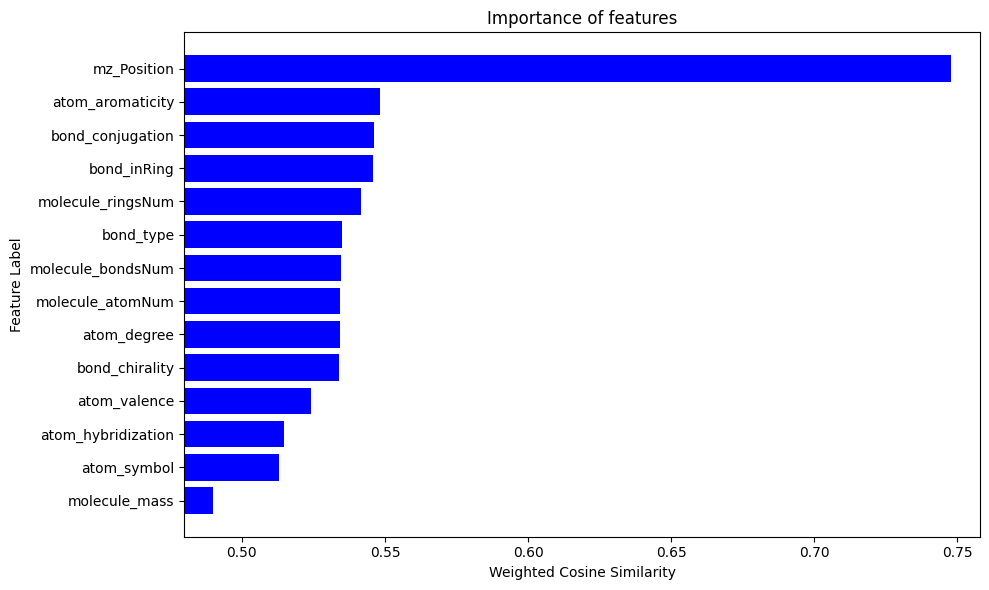

In [161]:
import matplotlib.pyplot as plt

# Sort the feature dictionary by values in descending order
sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=False)

# Extract labels and values for plotting
labels, values = zip(*sorted_features)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(labels)), values, color='blue')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Weighted Cosine Similarity')
plt.ylabel('Feature Label')
plt.title('Importance of features')
plt.xlim(min(values) - 0.01, max(values) + 0.01)  # Set the y-axis limit
plt.tight_layout()

# Show the plot
plt.show()


## Part 6: Evalute the effect of m/z Position

### Random Forest

In [18]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [19]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[13:25:38] WARNING: not removing hydrogen atom without neighbors
[13:25:38] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'Te', 'S', 'Se', 'Cl', 'Br', 'Sn', 'Sb', 'Hg', 'In', 'Zn', 'Bi', 'Kr', 'Cd', 'B', 'H', 'Fe', 'Co', 'Mn', 'Pb', 'P', 'Xe', 'Si', 'C', 'Na', 'N', 'Ar', 'U', 'Ni', 'Ge', 'As', 'Re', 'Al', 'F', 'Tl', 'O', 'W', 'Rh', 'Mo', 'K', 'I'}
40


In [20]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]
df.head()


[13:25:48] WARNING: not removing hydrogen atom without neighbors
[13:25:50] WARNING: not removing hydrogen atom without neighbors


features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [21]:
# do the normalisation on spectrum data

def normalisation(spectrum):
  spectrum = np.array(spectrum)

  # Compute the sum of all non-zero elements
  sum_non_zero = np.sum(spectrum[spectrum != 0])

  # Normalize the vector by dividing each non-zero element by the sum
  normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)

  return normalized_spectrum


df['spectrum'] = df['spectrum'].apply(lambda x: normalisation(x))
df.head()

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [22]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)

  return np.concatenate([features, new_arr])

df['features'] = df.apply(add_mz_metadata, axis=1)
df.head() # dimension of features is 377; dimension of spectrum is 300

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [10]:
len(df['features'][0])

377

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, spectrum, test_size=0.2, random_state=8888)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8888)

In [24]:


def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to("cpu").numpy()

In [25]:
import joblib

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=666)

'''
Hyper parameters used in Random Forest Regressor:

1. n_estimators: This hyperparameter determines the number of decision trees in the random forest.
Increasing the number of estimators can improve the model's performance, but it also increases training time

2. max_depth: This sets the maximum depth of each individual decision tree in the forest.
A deeper tree can capture more complex relationships in the data, but it may also lead to overfitting

'''

rf_regressor.fit(X_train, y_train)

# Predict the spectrum values for the test set
predicted_spectrum = rf_regressor.predict(X_val)

# Calculate the weighted cosine similarity for the test set
weighted_similarity = WeightedSimlarity(torch.tensor(predicted_spectrum), torch.tensor(y_val))

# Calculate the average weighted cosine similarity
average_similarity = torch.mean(torch.tensor(weighted_similarity))
print("Average Weighted Cosine Similarity:", average_similarity.item()) # 0.5275508464906629

joblib.dump(rf_regressor, "/content/drive/My Drive/individualProject/random_forest_without_mz.pkl")

Average Weighted Cosine Similarity: 0.5275508464906629


['/content/drive/My Drive/individualProject/random_forest_without_mz.pkl']

### Vanilla MLP

In [5]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [6]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[22:36:24] WARNING: not removing hydrogen atom without neighbors
[22:36:24] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'Mo', 'Sn', 'C', 'Ge', 'U', 'I', 'Cd', 'Hg', 'Se', 'H', 'O', 'Fe', 'Ni', 'Cl', 'As', 'Xe', 'Co', 'Pb', 'Si', 'Sb', 'N', 'S', 'Al', 'Ar', 'Te', 'Bi', 'B', 'Re', 'Mn', 'Tl', 'Zn', 'F', 'In', 'Rh', 'W', 'Br', 'K', 'Na', 'Kr', 'P'}
40


In [7]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]
df.head()


[22:36:34] WARNING: not removing hydrogen atom without neighbors
[22:36:35] WARNING: not removing hydrogen atom without neighbors


features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [8]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)

  return np.concatenate([features, new_arr])

df['features'] = df.apply(add_mz_metadata, axis=1)
df.head() # dimension of features is 377; dimension of spectrum is 300

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [9]:
len(df['features'][0])

377

In [10]:
import torch
import torch.nn as nn

# the optimal MLP architecture has 7 hidden layers of 2000 nodes,
# with residual network connections between the layers, using ReLU activation and a dropout rate of 0.25

class MLPRegressor(nn.Module):
    def __init__(self, dropout):
        super(MLPRegressor, self).__init__()

        self.input_layer = nn.Linear(377, 400)

        self.hidden_layer_1 = nn.Linear(400, 400)

        # 400 * 3 + 200 * 4 = 2000 nodes

        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)

        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, input):

        hidden = self.input_layer(input) # 377 -> 400
        hidden = self.dropout(hidden) # 400 -> 400

        for layer in range(3):
          x = hidden # do the redsidual connection
          hidden = self.hidden_layer_1(hidden) # 400 -> 400
          hidden += x
          hidden = self.dropout(hidden) # 400 -> 400

        hidden = self.hidden_layer_2(hidden) # 400 -> 200
        hidden = self.dropout(hidden) # 200 -> 200

        for layer in range(3):
          x = hidden # do the residual connection
          hidden = self.hidden_layer_3(hidden) # 200 -> 200
          hidden += x
          hidden = self.dropout(hidden) # 200 -> 200

        output = self.output_layer(hidden)  # 200 -> 300
        output = self.relu(output) # 300 -> 300

        return output

In [11]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WeightedMSELoss, self).__init__()

    def forward(self, outputs, targets, smooth=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

        # I -> m * (I)^(0.5)
        outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
        targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

        # the squared sum of m * (I)^(0.5), add the smooth to prevent nan
        outputsSquaredSum = torch.add(torch.sum(torch.pow(outputs, 2), 1), smooth).unsqueeze(1).to(device)
        targetsSqauredSum = torch.add(torch.sum(torch.pow(targets, 2), 1), smooth).unsqueeze(1).to(device)

        # m * (I)^(0.5) -> m * (I)^(0.5) / squared sum
        outputs = torch.div(outputs, outputsSquaredSum).to(device)
        targets = torch.div(targets, targetsSqauredSum).to(device)

        # take the difference of target and outputs, and get squared sum
        return torch.sum(torch.sum(torch.pow(torch.sub(targets, outputs), 2) , 1)).to(device)

In [12]:
import torch.nn.functional as F

def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to(device)

In [13]:
from sklearn.model_selection import train_test_split, KFold

features = torch.tensor(np.array(df['features'].tolist()))
spectrums = torch.tensor(np.array(df['spectrum'].tolist()))

dataset = TensorDataset(features, spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create a KFold cross-validation object with 3 folds
kf = KFold(n_splits=5, shuffle=True, random_state=8888)

#### train

In [14]:
train_indices, val_indices = list(kf.split(train_dataset))[0]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [15]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 900

# train type
from_strach = True

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_0.pth'))

  max_sim = 0.570657976799541
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_without_mz_0.pth')


======== Epoch 1 / 1900 ========
Training...
update with validation similarity: 0.4302501206596692

======== Epoch 2 / 1900 ========
Training...
update with validation similarity: 0.4442242582639058

======== Epoch 3 / 1900 ========
Training...
update with validation similarity: 0.4924325073758761

======== Epoch 4 / 1900 ========
Training...
update with validation similarity: 0.5235846845640076

======== Epoch 5 / 1900 ========
Training...
update with validation similarity: 0.5278511080476973

======== Epoch 6 / 1900 ========
Training...
update with validation similarity: 0.5396860233611531

======== Epoch 7 / 1900 ========
Training...
update with validation similarity: 0.5423822336726718

======== Epoch 8 / 1900 ========
Training...
update with validation similarity: 0.5473927292558882

======== Epoch 9 / 1900 ========
Training...
update with validation similarity: 0.5489401784208086

======== Epoch 10 / 1900 ========
Training...
update with validation similarity: 0.5490713682439592

KeyboardInterrupt: ignored

In [16]:
train_indices, val_indices = list(kf.split(train_dataset))[1]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [17]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 900

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_1.pth'))

  max_sim = 0.5745670563644834
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_without_mz_1.pth')


======== Epoch 1 / 900 ========
Training...
update with validation similarity: 0.43048881739377975

======== Epoch 2 / 900 ========
Training...
update with validation similarity: 0.4934523130456607

======== Epoch 3 / 900 ========
Training...
update with validation similarity: 0.5343438138564428

======== Epoch 4 / 900 ========
Training...
update with validation similarity: 0.5384413980775409

======== Epoch 5 / 900 ========
Training...
update with validation similarity: 0.5423948450220956

======== Epoch 6 / 900 ========
Training...
update with validation similarity: 0.5470130062765546

======== Epoch 7 / 900 ========
Training...
update with validation similarity: 0.5486436262726784

======== Epoch 8 / 900 ========
Training...
update with validation similarity: 0.5500257934133211

======== Epoch 9 / 900 ========
Training...
update with validation similarity: 0.5508173008759817

======== Epoch 10 / 900 ========
Training...
update with validation similarity: 0.5519654568698671

=======

In [18]:
train_indices, val_indices = list(kf.split(train_dataset))[2]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [19]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 900

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_2.pth'))

  max_sim = 0.5683316737413406
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_without_mz_2.pth')


======== Epoch 1 / 900 ========
Training...
update with validation similarity: 0.4302055297626389

======== Epoch 2 / 900 ========
Training...

======== Epoch 3 / 900 ========
Training...
update with validation similarity: 0.5104882311489847

======== Epoch 4 / 900 ========
Training...
update with validation similarity: 0.5265630400843091

======== Epoch 5 / 900 ========
Training...
update with validation similarity: 0.5326511934399605

======== Epoch 6 / 900 ========
Training...
update with validation similarity: 0.5374598660402827

======== Epoch 7 / 900 ========
Training...
update with validation similarity: 0.5401474626527892

======== Epoch 8 / 900 ========
Training...
update with validation similarity: 0.540954108039538

======== Epoch 9 / 900 ========
Training...
update with validation similarity: 0.5450076709191004

======== Epoch 10 / 900 ========
Training...
update with validation similarity: 0.5465217696295844

======== Epoch 11 / 900 ========
Training...
update with valida

In [20]:
train_indices, val_indices = list(kf.split(train_dataset))[3]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [21]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1900

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_3.pth'))

  max_sim = 0.5677224695682526
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_without_mz_3.pth')


======== Epoch 1 / 1900 ========
Training...
update with validation similarity: 0.42559722314278287

======== Epoch 2 / 1900 ========
Training...
update with validation similarity: 0.4492102646165424

======== Epoch 3 / 1900 ========
Training...
update with validation similarity: 0.4932498302724626

======== Epoch 4 / 1900 ========
Training...
update with validation similarity: 0.5200051243106524

======== Epoch 5 / 1900 ========
Training...
update with validation similarity: 0.5267385327153735

======== Epoch 6 / 1900 ========
Training...
update with validation similarity: 0.5347163511647118

======== Epoch 7 / 1900 ========
Training...
update with validation similarity: 0.5391687734259499

======== Epoch 8 / 1900 ========
Training...
update with validation similarity: 0.5408463569151031

======== Epoch 9 / 1900 ========
Training...
update with validation similarity: 0.5425142447153727

======== Epoch 10 / 1900 ========
Training...
update with validation similarity: 0.544021364715364

KeyboardInterrupt: ignored

In [22]:
train_indices, val_indices = list(kf.split(train_dataset))[4]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [23]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 900

# train type
from_strach = False

backwardMLP = MLPRegressor(0.25)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=5e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_4.pth'))

  max_sim = 0.5711767358912362
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_labels = batch[1].to(torch.float32).to(device)

          output = backwardMLP(b_input)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1


    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/vanillaMLP_without_mz_4.pth')


======== Epoch 1 / 900 ========
Training...
update with validation similarity: 0.42806627601385117

======== Epoch 2 / 900 ========
Training...
update with validation similarity: 0.450394868850708

======== Epoch 3 / 900 ========
Training...
update with validation similarity: 0.5261811324291759

======== Epoch 4 / 900 ========
Training...
update with validation similarity: 0.5372457289033465

======== Epoch 5 / 900 ========
Training...
update with validation similarity: 0.5397297408845689

======== Epoch 6 / 900 ========
Training...
update with validation similarity: 0.543207709160116

======== Epoch 7 / 900 ========
Training...
update with validation similarity: 0.548844589955277

======== Epoch 8 / 900 ========
Training...
update with validation similarity: 0.5512940850522783

======== Epoch 9 / 900 ========
Training...
update with validation similarity: 0.5514934808015823

======== Epoch 10 / 900 ========
Training...
update with validation similarity: 0.552221934000651

======== Ep

#### evaluation

In [24]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [25]:
backwardMLP_1 = MLPRegressor(0.25)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_0.pth'))
# 0.570657976799541

backwardMLP_2 = MLPRegressor(0.25)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_1.pth'))
# 0.5745670563644834

backwardMLP_3 = MLPRegressor(0.25)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_2.pth'))
# 0.5683316737413406

backwardMLP_4 = MLPRegressor(0.25)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_3.pth'))
# 0.5677224695682526

backwardMLP_5 = MLPRegressor(0.25)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_without_mz_4.pth'))
# 0.5711767358912362


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input)
      output_2 = backwardMLP_2(b_input)
      output_3 = backwardMLP_3(b_input)
      output_4 = backwardMLP_4(b_input)
      output_5 = backwardMLP_5(b_input)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      batch_sim = WeightedSimlarity(output, b_labels)
      total_test_sim += torch.mean(batch_sim).item()

      max_test_step += 1

print(
    f'''Test similarity: {total_test_sim / max_test_step}''') # 0.5728891756799486

Test similarity: 0.5728891756799486


### CNN MLP

In [5]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion
df.head()

name  \
0          (+)-p-Bromo-.alpha.-phenethylamine   
1             (-)-1-(4-Bromophenyl)ethylamine   
2  (.eta.5-cyclopentadienyl)dicarbonylrhodium   
3   (1-Hydroxy-2,2,2-trichloroethyl)formamide   
4         (1R,2R)-(+)-1-Phenylpropylene oxide   

                                 compound  \
0                    CC(C1=CC=C(C=C1)Br)N   
1                    CC(C1=CC=C(C=C1)Br)N   
2  [C-]#[O+].[C-]#[O+].[CH-]1C=CC=C1.[Rh]   
3                   C(=O)NC(C(Cl)(Cl)Cl)O   
4            C[C@@H]1[C@H](O1)C2=CC=CC=C2   

                                                ecfp  \
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [6]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[19:23:07] WARNING: not removing hydrogen atom without neighbors
[19:23:07] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'S', 'Re', 'I', 'Fe', 'K', 'Zn', 'Se', 'As', 'Ge', 'Te', 'Kr', 'Al', 'Cl', 'In', 'N', 'Co', 'Xe', 'Na', 'W', 'Sb', 'P', 'Sn', 'H', 'Hg', 'Br', 'Bi', 'Ni', 'Tl', 'Mo', 'C', 'F', 'Pb', 'Rh', 'Si', 'Ar', 'Mn', 'Cd', 'U', 'B', 'O'}
40


In [7]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]
df.head()

[19:23:19] WARNING: not removing hydrogen atom without neighbors
[19:23:20] WARNING: not removing hydrogen atom without neighbors


features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [8]:
# do the normalisation on spectrum data

def normalisation(spectrum):
  spectrum = np.array(spectrum)

  # Compute the sum of all non-zero elements
  sum_non_zero = np.sum(spectrum[spectrum != 0])

  # Normalize the vector by dividing each non-zero element by the sum
  normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)

  return normalized_spectrum


df['spectrum'] = df['spectrum'].apply(lambda x: normalisation(x))
df.head()

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [9]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)

  return new_arr

df['positions'] = df.apply(add_mz_metadata, axis=1)
df.head() # dimension of features is 377; dimension of spectrum is 300

features  \
0  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
1  [200.07900000000006, 20.0, 20.0, 1.0, 0.0, 0.0...   
2  [224.02100000000004, 15.0, 12.0, 1.0, 0.0, 0.0...   
3  [192.42900000000003, 13.0, 12.0, 0.0, 0.0, 0.0...   
4  [134.17800000000003, 20.0, 21.0, 2.0, 0.0, 0.0...   

                                            spectrum  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           positions  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [31]:
len(df['positions'][0])

300

In [32]:
len(df['features'][0])

77

In [10]:
import torch
import torch.nn as nn

class CNN_MLP(nn.Module):
    def __init__(self, num_layers, dropout=0.5):
        super(CNN_MLP, self).__init__()

        layers = []
        in_channels = 1
        out_channels = 64  # Number of channels in the first convolutional layer

        # Add convolutional layers
        for i in range(num_layers):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            in_channels = out_channels
            out_channels *= 2  # Double the number of channels in each layer

        self.conv_layers = nn.Sequential(*layers)

        # Calculate the input size for the fully connected layer
        self.fc_layer = nn.Linear(in_channels*77+300, 200)

        # MLP layers
        self.input_layer = nn.Linear(200, 400)
        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, positions):  # [32, 77], [32, 300]
        x = x.unsqueeze(1) # [32, 1, 77]

        cnn_out = self.conv_layers(x) # [32, 128, 77]
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # [32, 9856]

        cnn_out = torch.cat((cnn_out, positions), dim=1) # [32, 10156]
        cnn_out = self.fc_layer(cnn_out) # [32, 200]

        # MLP forward pass
        hidden = self.input_layer(cnn_out) # [32, 400]
        hidden = self.dropout(hidden) # [32, 400]

        for _ in range(3):
            x = hidden
            hidden = self.hidden_layer_1(hidden) # [32, 400]
            hidden += x
            hidden = self.dropout(hidden) # [32, 400]

        hidden = self.hidden_layer_2(hidden) # [32, 200]
        hidden = self.dropout(hidden)  # [32, 200]

        for _ in range(3):
            x = hidden
            hidden = self.hidden_layer_3(hidden) # [32, 200]
            hidden += x
            hidden = self.dropout(hidden) # [32, 200]

        output = self.output_layer(hidden) # [32, 300]
        output = self.relu(output) # [32, 300]

        return output # [32, 300]


In [11]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WeightedMSELoss, self).__init__()

    def forward(self, outputs, targets, smooth=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

        # I -> m * (I)^(0.5)
        outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
        targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

        # the squared sum of m * (I)^(0.5), add the smooth to prevent nan
        outputsSquaredSum = torch.add(torch.sum(torch.pow(outputs, 2), 1), smooth).unsqueeze(1).to(device)
        targetsSqauredSum = torch.add(torch.sum(torch.pow(targets, 2), 1), smooth).unsqueeze(1).to(device)

        # m * (I)^(0.5) -> m * (I)^(0.5) / squared sum
        outputs = torch.div(outputs, outputsSquaredSum).to(device)
        targets = torch.div(targets, targetsSqauredSum).to(device)

        # take the difference of target and outputs, and get squared sum
        return torch.sum(torch.sum(torch.pow(torch.sub(targets, outputs), 2) , 1)).to(device)

In [12]:
import torch.nn.functional as F

def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to(device)

In [13]:
from sklearn.model_selection import train_test_split, KFold

features = torch.tensor(np.array(df['features'].tolist()))
positions = torch.tensor(np.array(df['positions'].tolist()))
spectrums = torch.tensor(np.array(df['spectrum'].tolist()))

dataset = TensorDataset(features, positions, spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create a KFold cross-validation object with 3 folds
kf = KFold(n_splits=5, shuffle=True, random_state=8888)

#### train

In [14]:
train_indices, val_indices = list(kf.split(train_dataset))[0]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [18]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 200

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.1)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-5, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_0.pth'))

  max_sim = 0.5761085400978724
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_0.pth')


======== Epoch 1 / 200 ========
Training...
update with validation similarity: 0.46686047067244846

======== Epoch 2 / 200 ========
Training...
update with validation similarity: 0.4835263109869427

======== Epoch 3 / 200 ========
Training...
update with validation similarity: 0.4908753956357638

======== Epoch 4 / 200 ========
Training...
update with validation similarity: 0.4952137561308013

======== Epoch 5 / 200 ========
Training...
update with validation similarity: 0.5067248062955009

======== Epoch 6 / 200 ========
Training...

======== Epoch 7 / 200 ========
Training...

======== Epoch 8 / 200 ========
Training...
update with validation similarity: 0.5106179366509119

======== Epoch 9 / 200 ========
Training...
update with validation similarity: 0.5166341877645917

======== Epoch 10 / 200 ========
Training...

======== Epoch 11 / 200 ========
Training...

======== Epoch 12 / 200 ========
Training...

======== Epoch 13 / 200 ========
Training...

======== Epoch 14 / 200 =======

In [66]:
train_indices, val_indices = list(kf.split(train_dataset))[1]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [67]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1300

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.1)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_1.pth'))

  max_sim = 0.5779231803284751
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_1.pth')


======== Epoch 1 / 1300 ========
Training...
update with validation similarity: 0.3925999427835147

======== Epoch 2 / 1300 ========
Training...
update with validation similarity: 0.39281683829095626

======== Epoch 3 / 1300 ========
Training...
update with validation similarity: 0.39305350598361755

======== Epoch 4 / 1300 ========
Training...
update with validation similarity: 0.3932998834384812

======== Epoch 5 / 1300 ========
Training...
update with validation similarity: 0.39355628854698604

======== Epoch 6 / 1300 ========
Training...
update with validation similarity: 0.3938378443320592

======== Epoch 7 / 1300 ========
Training...
update with validation similarity: 0.39412134803003734

======== Epoch 8 / 1300 ========
Training...
update with validation similarity: 0.39441458466980195

======== Epoch 9 / 1300 ========
Training...
update with validation similarity: 0.3947151154279709

======== Epoch 10 / 1300 ========
Training...
update with validation similarity: 0.39502944052

In [68]:
train_indices, val_indices = list(kf.split(train_dataset))[2]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [69]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1300

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.1)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_2.pth'))

  max_sim = 0.5715788205464681
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_2.pth')


======== Epoch 1 / 1300 ========
Training...
update with validation similarity: 0.3940081240402328

======== Epoch 2 / 1300 ========
Training...
update with validation similarity: 0.39432768109771943

======== Epoch 3 / 1300 ========
Training...
update with validation similarity: 0.39468397696812946

======== Epoch 4 / 1300 ========
Training...
update with validation similarity: 0.39503450360563064

======== Epoch 5 / 1300 ========
Training...
update with validation similarity: 0.3954047312339147

======== Epoch 6 / 1300 ========
Training...
update with validation similarity: 0.3957886654469702

======== Epoch 7 / 1300 ========
Training...
update with validation similarity: 0.3961794111463759

======== Epoch 8 / 1300 ========
Training...
update with validation similarity: 0.39658811853991616

======== Epoch 9 / 1300 ========
Training...
update with validation similarity: 0.3970144498679373

======== Epoch 10 / 1300 ========
Training...
update with validation similarity: 0.397457131908

In [71]:
train_indices, val_indices = list(kf.split(train_dataset))[3]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [72]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1300

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.1)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_3.pth'))

  max_sim = 0.5674039953284793
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_3.pth')


======== Epoch 1 / 1300 ========
Training...
update with validation similarity: 0.3920034012860722

======== Epoch 2 / 1300 ========
Training...
update with validation similarity: 0.3923264170686404

======== Epoch 3 / 1300 ========
Training...
update with validation similarity: 0.39266934908098644

======== Epoch 4 / 1300 ========
Training...
update with validation similarity: 0.39301178107659024

======== Epoch 5 / 1300 ========
Training...
update with validation similarity: 0.39336970696846646

======== Epoch 6 / 1300 ========
Training...
update with validation similarity: 0.39374028891324997

======== Epoch 7 / 1300 ========
Training...
update with validation similarity: 0.39410388966401416

======== Epoch 8 / 1300 ========
Training...
update with validation similarity: 0.3944813874032762

======== Epoch 9 / 1300 ========
Training...
update with validation similarity: 0.39485857801304924

======== Epoch 10 / 1300 ========
Training...
update with validation similarity: 0.3952466961

KeyboardInterrupt: ignored

In [73]:
train_indices, val_indices = list(kf.split(train_dataset))[4]

train_fold_data = torch.utils.data.Subset(train_dataset, train_indices)
val_fold_data = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 32

# Create train and validation data loaders
train_dataloader = DataLoader(
    train_fold_data,
    sampler=RandomSampler(train_fold_data),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_fold_data,
    sampler=SequentialSampler(val_fold_data),
    batch_size=batch_size
)

In [74]:
from pickle import TRUE

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# For each batch of training data...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyper-parameters
epochs = 1300

# train type
from_strach = False

num_layers = 3
backwardMLP = CNN_MLP(num_layers, 0.1)

# define the loss function and optimizer
optimizer = torch.optim.Adam(backwardMLP.parameters(), lr=1e-2, betas=(0.5, 0.999))

loss = WeightedMSELoss()

# do the training
max_sim = 0

if not from_strach:

  backwardMLP.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_4.pth'))

  max_sim = 0.57197881076071
  print("load the checkpoints")


for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_sim = 0

    # set the model into train mode
    backwardMLP.train()

    max_train_step = 0
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
      if step % 500 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      if torch.cuda.is_available():
        backwardMLP = backwardMLP.cuda()
        loss = loss.cuda()

      output = backwardMLP(b_input, b_positions)

      batch_loss = loss(output, b_labels)
      total_train_loss += batch_loss.item()

      batch_sim = WeightedSimlarity(output, b_labels)
      total_train_sim += torch.mean(batch_sim).item()
      max_train_step += 1


      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    total_val_loss = 0
    total_val_sim = 0

    backwardMLP.eval()

    max_val_step = 0
    with torch.no_grad():
      for step, batch in enumerate(val_dataloader):


          b_input = batch[0].to(torch.float32).to(device)
          b_positions = batch[1].to(torch.float32).to(device)
          b_labels = batch[2].to(torch.float32).to(device)

          output = backwardMLP(b_input, b_positions)

          batch_loss = loss(output, b_labels)
          total_val_loss += batch_loss.item()

          batch_sim = WeightedSimlarity(output, b_labels)
          total_val_sim += torch.mean(batch_sim).item()

          max_val_step += 1

    if (total_val_sim / max_val_step) > max_sim:
      max_sim = total_val_sim / max_val_step
      print("update with validation similarity: " + str(max_sim))
      torch.save(backwardMLP.state_dict(), '/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_4.pth')


======== Epoch 1 / 1300 ========
Training...
update with validation similarity: 0.39702099478907055

======== Epoch 2 / 1300 ========
Training...
update with validation similarity: 0.39718300683630836

======== Epoch 3 / 1300 ========
Training...
update with validation similarity: 0.39736547735002303

======== Epoch 4 / 1300 ========
Training...
update with validation similarity: 0.39755946066644454

======== Epoch 5 / 1300 ========
Training...
update with validation similarity: 0.39776434583796394

======== Epoch 6 / 1300 ========
Training...
update with validation similarity: 0.3979824284712474

======== Epoch 7 / 1300 ========
Training...
update with validation similarity: 0.39853298084603417

======== Epoch 8 / 1300 ========
Training...
update with validation similarity: 0.39891548620329964

======== Epoch 9 / 1300 ========
Training...
update with validation similarity: 0.3993295638097657

======== Epoch 10 / 1300 ========
Training...
update with validation similarity: 0.399811286

#### evaluate

In [75]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [76]:
backwardMLP_1 = CNN_MLP(3, 0.15)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_0.pth'))
# 0.5761085400978724

backwardMLP_2 = CNN_MLP(3, 0.15)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_1.pth'))
# 0.5779231803284751

backwardMLP_3 = CNN_MLP(3, 0.15)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_2.pth'))
# 0.5715788205464681

backwardMLP_4 = CNN_MLP(3, 0.15)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_3.pth'))
# 0.5674039953284793

backwardMLP_5 = CNN_MLP(3, 0.15)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_without_mz_4.pth'))
# 0.57197881076071


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input, b_positions)
      output_2 = backwardMLP_2(b_input, b_positions)
      output_3 = backwardMLP_3(b_input, b_positions)
      output_4 = backwardMLP_4(b_input, b_positions)
      output_5 = backwardMLP_5(b_input, b_positions)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      batch_sim = WeightedSimlarity(output, b_labels)
      total_test_sim += torch.mean(batch_sim).item()

      max_test_step += 1

print(
    f'''Test similarity: {total_test_sim / max_test_step}''') # 0.576065813170539

Test similarity: 0.576065813170539


### Visualise the effect of m/z position

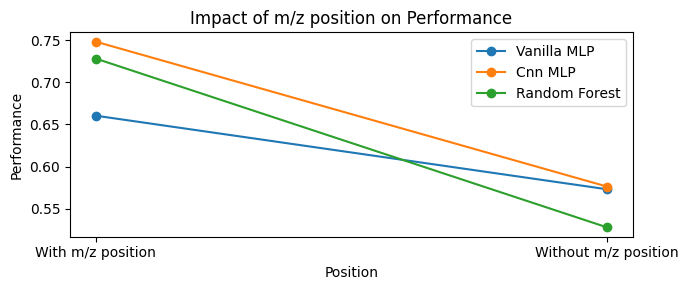

In [100]:
import matplotlib.pyplot as plt

# Data dictionary
feature_dict = {
    'Vanilla MLP': [0.6604596164491442, 0.5728891756799486],
    'Cnn MLP': [0.7484978424178229, 0.576065813170539],
    'Random Forest': [0.7283914209226714, 0.5275508464906629]
}

# Create a figure and axis
plt.figure(figsize=(7, 3))
ax = plt.gca()

# Plot lines for each model's data
for model_name, model_data in feature_dict.items():
    plt.plot(['With m/z position', 'Without m/z position'], model_data, marker='o', label=model_name)

# Add labels, title, and legend
plt.xlabel('Position')
plt.ylabel('Performance')
plt.title('Impact of m/z position on Performance')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Part 7: Inference Result Evaluation

### Base Model

In [86]:
data = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')


# 将字符串列转换回整数列表
data['ecfp'] = data['ecfp'].apply(lambda x: eval(x))
data['spectrum'] = data['spectrum'].apply(lambda x: eval(x))
data = data[['ecfp', 'spectrum']]

data['reverse_spectrum'] = data['spectrum'].apply(lambda x : x[::-1])

<ipython-input-86-413c552bfa82>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['reverse_spectrum'] = data['spectrum'].apply(lambda x : x[::-1])


In [87]:
import torch
import torch.nn as nn

# the optimal MLP architecture has 7 hidden layers of 2000 nodes,
# with residual network connections between the layers, using ReLU activation and a dropout rate of 0.25

class MLPRegressor(nn.Module):
    def __init__(self, dropout):
        super(MLPRegressor, self).__init__()

        self.input_layer = nn.Linear(4096, 400)

        self.hidden_layer_1 = nn.Linear(400, 400)

        # 400 * 3 + 200 * 4 = 2000 nodes

        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)

        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, input):

        hidden = self.input_layer(input) # 4096 -> 400
        hidden = self.dropout(hidden) # 400 -> 400

        for layer in range(3):
          x = hidden # do the redsidual connection
          hidden = self.hidden_layer_1(hidden) # 400 -> 400
          hidden += x
          hidden = self.dropout(hidden) # 400 -> 400

        hidden = self.hidden_layer_2(hidden) # 400 -> 200
        hidden = self.dropout(hidden) # 200 -> 200

        for layer in range(3):
          x = hidden # do the residual connection
          hidden = self.hidden_layer_3(hidden) # 200 -> 200
          hidden += x
          hidden = self.dropout(hidden) # 200 -> 200

        output = self.output_layer(hidden)  # 200 -> 300
        output = self.relu(output) # 300 -> 300

        return output

In [88]:
from sklearn.model_selection import train_test_split, KFold

ecfps = torch.tensor(np.array(data['ecfp'].tolist()))
reverse_spectrums = torch.tensor(np.array(data['reverse_spectrum'].tolist()))

dataset = TensorDataset(ecfps, reverse_spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
_, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [89]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [90]:
backwardMLP_1 = MLPRegressor(0.25)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_0.pth', map_location=torch.device('cpu')))

backwardMLP_2 = MLPRegressor(0.25)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_1.pth', map_location=torch.device('cpu')))

backwardMLP_3 = MLPRegressor(0.25)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_2.pth', map_location=torch.device('cpu')))

backwardMLP_4 = MLPRegressor(0.25)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_3.pth', map_location=torch.device('cpu')))

backwardMLP_5 = MLPRegressor(0.25)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/backwardMLP_best_4.pth', map_location=torch.device('cpu')))


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

max_test_step = 0
total_test_sim = 0
device = 'cpu'

baseModelOutput = []

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input)
      output_2 = backwardMLP_2(b_input)
      output_3 = backwardMLP_3(b_input)
      output_4 = backwardMLP_4(b_input)
      output_5 = backwardMLP_5(b_input)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      baseModelOutput += output

# 1415-length

In [91]:
# Define the normalization function
def normalisation(spectrum):
    spectrum = np.array(spectrum)
    sum_non_zero = np.sum(spectrum[spectrum != 0])
    normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)
    return normalized_spectrum

normalized_output = []
for row in baseModelOutput:
    normalized_output.append(normalisation(row))

baseModelOutput = normalized_output

### Random Forest

In [92]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion


In [93]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[23:22:25] WARNING: not removing hydrogen atom without neighbors
[23:22:25] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'In', 'Bi', 'N', 'Fe', 'Cl', 'K', 'Re', 'Si', 'Rh', 'Zn', 'Br', 'C', 'Se', 'S', 'Hg', 'Mo', 'F', 'W', 'B', 'Xe', 'Te', 'Sb', 'P', 'I', 'Cd', 'Kr', 'Pb', 'Ni', 'Ar', 'Sn', 'Mn', 'Na', 'As', 'Ge', 'O', 'H', 'Tl', 'Al', 'U', 'Co'}
40


In [94]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]

[23:22:35] WARNING: not removing hydrogen atom without neighbors
[23:22:36] WARNING: not removing hydrogen atom without neighbors


In [95]:
# do the normalisation on spectrum data

def normalisation(spectrum):
  spectrum = np.array(spectrum)

  # Compute the sum of all non-zero elements
  sum_non_zero = np.sum(spectrum[spectrum != 0])

  # Normalize the vector by dividing each non-zero element by the sum
  normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)

  return normalized_spectrum


df['spectrum'] = df['spectrum'].apply(lambda x: normalisation(x))

In [96]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)
  new_arr[non_zero_indices] = 1

  return np.concatenate([features, new_arr])

df['features'] = df.apply(add_mz_metadata, axis=1)

In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F
import joblib

# Split data into features and spectrum
features = np.array(df["features"].tolist())
spectrum = np.array(df["spectrum"].tolist())

# Split data into training and testing sets
_, X_test, _, y_test = train_test_split(features, spectrum, test_size=0.2, random_state=8888)

rf_regressor = joblib.load("/content/drive/My Drive/individualProject/random_forest_best.pkl")

# Predict the spectrum values for the test set
randomForestOutput = rf_regressor.predict(X_test)
# 1415-length

### Vanilla MLP

In [98]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion

In [99]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[23:22:53] WARNING: not removing hydrogen atom without neighbors
[23:22:53] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'In', 'Bi', 'N', 'Fe', 'Cl', 'K', 'Re', 'Si', 'Rh', 'Zn', 'Br', 'C', 'Se', 'S', 'Hg', 'Mo', 'F', 'W', 'B', 'Xe', 'Te', 'Sb', 'P', 'I', 'Cd', 'Kr', 'Pb', 'Ni', 'Ar', 'Sn', 'Mn', 'Na', 'As', 'Ge', 'O', 'H', 'Tl', 'Al', 'U', 'Co'}
40


In [100]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]

[23:23:03] WARNING: not removing hydrogen atom without neighbors
[23:23:04] WARNING: not removing hydrogen atom without neighbors


In [101]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)
  new_arr[non_zero_indices] = 1

  return np.concatenate([features, new_arr])

df['features'] = df.apply(add_mz_metadata, axis=1)

In [102]:
import torch
import torch.nn as nn

# the optimal MLP architecture has 7 hidden layers of 2000 nodes,
# with residual network connections between the layers, using ReLU activation and a dropout rate of 0.25

class MLPRegressor(nn.Module):
    def __init__(self, dropout):
        super(MLPRegressor, self).__init__()

        self.input_layer = nn.Linear(377, 400)

        self.hidden_layer_1 = nn.Linear(400, 400)

        # 400 * 3 + 200 * 4 = 2000 nodes

        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)

        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, input):

        hidden = self.input_layer(input) # 377 -> 400
        hidden = self.dropout(hidden) # 400 -> 400

        for layer in range(3):
          x = hidden # do the redsidual connection
          hidden = self.hidden_layer_1(hidden) # 400 -> 400
          hidden += x
          hidden = self.dropout(hidden) # 400 -> 400

        hidden = self.hidden_layer_2(hidden) # 400 -> 200
        hidden = self.dropout(hidden) # 200 -> 200

        for layer in range(3):
          x = hidden # do the residual connection
          hidden = self.hidden_layer_3(hidden) # 200 -> 200
          hidden += x
          hidden = self.dropout(hidden) # 200 -> 200

        output = self.output_layer(hidden)  # 200 -> 300
        output = self.relu(output) # 300 -> 300

        return output

In [103]:
from sklearn.model_selection import train_test_split, KFold

features = torch.tensor(np.array(df['features'].tolist()))
spectrums = torch.tensor(np.array(df['spectrum'].tolist()))

dataset = TensorDataset(features, spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
_, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [104]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [105]:
backwardMLP_1 = MLPRegressor(0.25)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_0.pth', map_location=torch.device('cpu')))

backwardMLP_2 = MLPRegressor(0.25)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_1.pth', map_location=torch.device('cpu')))

backwardMLP_3 = MLPRegressor(0.25)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_2.pth', map_location=torch.device('cpu')))

backwardMLP_4 = MLPRegressor(0.25)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_3.pth', map_location=torch.device('cpu')))

backwardMLP_5 = MLPRegressor(0.25)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/vanillaMLP_best_4.pth', map_location=torch.device('cpu')))


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

device = 'cpu'

vanillaMLPOutput = []

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_labels = batch[1].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input)
      output_2 = backwardMLP_2(b_input)
      output_3 = backwardMLP_3(b_input)
      output_4 = backwardMLP_4(b_input)
      output_5 = backwardMLP_5(b_input)

      output_list = [output_1, output_2, output_3, output_4, output_5]
      output = sum(output_list) / len(output_list)
      vanillaMLPOutput += output

# 1415-length

In [106]:
# Define the normalization function
def normalisation(spectrum):
    spectrum = np.array(spectrum)
    sum_non_zero = np.sum(spectrum[spectrum != 0])
    normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)
    return normalized_spectrum

normalized_output = []
for row in vanillaMLPOutput:
    normalized_output.append(normalisation(row))

vanillaMLPOutput = normalized_output

### Cnn MLP

In [107]:
df = pd.read_csv('/content/drive/My Drive/individualProject/train_data.csv')
df['spectrum'] = df['spectrum'].apply(lambda x: eval(x))
df['spectrum'] = df['spectrum'].apply(lambda x : x[::-1]) # add the reversion

In [108]:
# set that used to store all unique atom symbols
atom_symbols = set()


def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

# apply the above func to all compound smiles in dataframe
df['compound'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

[23:23:12] WARNING: not removing hydrogen atom without neighbors
[23:23:12] WARNING: not removing hydrogen atom without neighbors


Unique atom symbols: {'In', 'Bi', 'N', 'Fe', 'Cl', 'K', 'Re', 'Si', 'Rh', 'Zn', 'Br', 'C', 'Se', 'S', 'Hg', 'Mo', 'F', 'W', 'B', 'Xe', 'Te', 'Sb', 'P', 'I', 'Cd', 'Kr', 'Pb', 'Ni', 'Ar', 'Sn', 'Mn', 'Na', 'As', 'Ge', 'O', 'H', 'Tl', 'Al', 'U', 'Co'}
40


In [109]:
# Function to get additional features based on the name

from rdkit.Chem import Descriptors

def get_features(smiles):
  # Implement your logic to retrieve additional features based on the name
  # Return the additional features as a list or tensor
  res = []

  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)

  # Get all bonds in the molecule
  bonds = mol.GetBonds()

  concatenated_vector = np.zeros(73)

  # Iterate over each bond and retrieve the connected atom information
  for bond in bonds:
    atom1 = bond.GetBeginAtom()  # First atom in the bond
    atom2 = bond.GetEndAtom()  # Second atom in the bond

    # Create one-hot encoded vectors for atom1
    atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector = np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Create one-hot encoded vectors for atom2
    atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 40-length one-hot vector
    degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])  # Degree ranges from 0 to 6; 7-length one-hot vector
    valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)])  # Valence ranges from 0 to 6; 7-length one-hot vector
    hybridization_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
    aromaticity_vector = np.array([1 if atom2.GetIsAromatic() else 0]) # 1-length one-hot vector

    concatenated_atom_vector += np.concatenate([atom_symbol_vector, degree_vector, valence_vector, hybridization_vector, aromaticity_vector])

    # Bond type
    bond_type = bond.GetBondType().name

    # Conjugation (1 if conjugated, 0 if not)
    is_conjugated = 1 if bond.GetIsConjugated() else 0

    # In ring (1 if in a ring, 0 if not)
    is_in_ring = 1 if bond.IsInRing() else 0

    # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
    chirality = bond.GetStereo()

    # Create one-hot encoded vectors
    bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])
    conjugation_vector = np.array([is_conjugated])
    in_ring_vector = np.array([is_in_ring])
    chirality_vector = np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])

    concatenated_bond_vector = np.concatenate([bond_type_vector, conjugation_vector, in_ring_vector, chirality_vector])
    concatenated_vector += np.concatenate([concatenated_atom_vector, concatenated_bond_vector])

  # add some global information about given molecule
  molecular_mass = Descriptors.MolWt(mol)
  num_atoms = mol.GetNumAtoms()
  num_bonds = mol.GetNumBonds()
  num_rings = len(Chem.GetSymmSSSR(mol))

  concatenated_vector = np.concatenate([[molecular_mass, num_atoms, num_bonds, num_rings], concatenated_vector])

  return concatenated_vector # 77-length vector


df['features'] = df['compound'].apply(lambda x: get_features(x))
df = df[['features', 'spectrum']]

[23:23:22] WARNING: not removing hydrogen atom without neighbors
[23:23:23] WARNING: not removing hydrogen atom without neighbors


In [110]:
# do the normalisation on spectrum data

def normalisation(spectrum):
  spectrum = np.array(spectrum)

  # Compute the sum of all non-zero elements
  sum_non_zero = np.sum(spectrum[spectrum != 0])

  # Normalize the vector by dividing each non-zero element by the sum
  normalized_spectrum = np.where(spectrum != 0, spectrum / sum_non_zero, spectrum)

  return normalized_spectrum


df['spectrum'] = df['spectrum'].apply(lambda x: normalisation(x))

In [111]:
# do the normalisation on spectrum data

def add_mz_metadata(row):
  features = np.array(row['features'])
  spectrum = np.array(row['spectrum'])

  non_zero_indices = np.where(spectrum != 0)[0]
  new_arr = np.zeros_like(spectrum)
  new_arr[non_zero_indices] = 1

  return new_arr

df['positions'] = df.apply(add_mz_metadata, axis=1)

In [112]:
import torch
import torch.nn as nn

class CNN_MLP(nn.Module):
    def __init__(self, num_layers, dropout=0.5):
        super(CNN_MLP, self).__init__()

        layers = []
        in_channels = 1
        out_channels = 64  # Number of channels in the first convolutional layer

        # Add convolutional layers
        for i in range(num_layers):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            in_channels = out_channels
            out_channels *= 2  # Double the number of channels in each layer

        self.conv_layers = nn.Sequential(*layers)

        # Calculate the input size for the fully connected layer
        self.fc_layer = nn.Linear(in_channels*77+300, 200)

        # MLP layers
        self.input_layer = nn.Linear(200, 400)
        self.hidden_layer_1 = nn.Linear(400, 400)
        self.hidden_layer_2 = nn.Linear(400, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 300)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, positions):  # [32, 77], [32, 300]
        x = x.unsqueeze(1) # [32, 1, 77]

        cnn_out = self.conv_layers(x) # [32, 128, 77]
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # [32, 9856]

        cnn_out = torch.cat((cnn_out, positions), dim=1) # [32, 10156]
        cnn_out = self.fc_layer(cnn_out) # [32, 200]

        # MLP forward pass
        hidden = self.input_layer(cnn_out) # [32, 400]
        hidden = self.dropout(hidden) # [32, 400]

        for _ in range(3):
            x = hidden
            hidden = self.hidden_layer_1(hidden) # [32, 400]
            hidden += x
            hidden = self.dropout(hidden) # [32, 400]

        hidden = self.hidden_layer_2(hidden) # [32, 200]
        hidden = self.dropout(hidden)  # [32, 200]

        for _ in range(3):
            x = hidden
            hidden = self.hidden_layer_3(hidden) # [32, 200]
            hidden += x
            hidden = self.dropout(hidden) # [32, 200]

        output = self.output_layer(hidden) # [32, 300]
        output = self.relu(output) # [32, 300]

        return output # [32, 300]


In [113]:
from sklearn.model_selection import train_test_split, KFold

features = torch.tensor(np.array(df['features'].tolist()))
positions = torch.tensor(np.array(df['positions'].tolist()))
spectrums = torch.tensor(np.array(df['spectrum'].tolist()))

dataset = TensorDataset(features, positions, spectrums)

# Split the dataset into train and test sets (80% train, 20% test)
_, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=8888)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [114]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32
)

In [115]:
backwardMLP_1 = CNN_MLP(3, 0.15)
backwardMLP_1.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_0.pth', map_location=torch.device('cpu')))

backwardMLP_2 = CNN_MLP(3, 0.15)
backwardMLP_2.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_1.pth', map_location=torch.device('cpu')))

backwardMLP_3 = CNN_MLP(3, 0.15)
backwardMLP_3.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_2.pth', map_location=torch.device('cpu')))

backwardMLP_4 = CNN_MLP(3, 0.15)
backwardMLP_4.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_3.pth', map_location=torch.device('cpu')))

backwardMLP_5 = CNN_MLP(3, 0.15)
backwardMLP_5.load_state_dict(torch.load('/content/drive/My Drive/individualProject/cnnMLP_layer_3_best_4.pth', map_location=torch.device('cpu')))


backwardMLP_1.eval()
backwardMLP_2.eval()
backwardMLP_3.eval()
backwardMLP_4.eval()
backwardMLP_5.eval()

device = 'cpu'
cnnMLPOutput = []
groundTruthOutput = []

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):


      b_input = batch[0].to(torch.float32).to(device)
      b_positions = batch[1].to(torch.float32).to(device)
      b_labels = batch[2].to(torch.float32).to(device)

      output_1 = backwardMLP_1(b_input, b_positions)
      output_2 = backwardMLP_2(b_input, b_positions)
      output_3 = backwardMLP_3(b_input, b_positions)
      output_4 = backwardMLP_4(b_input, b_positions)
      output_5 = backwardMLP_5(b_input, b_positions)

      output_list = [output_1, output_2, output_3, output_4, output_5]

      output = sum(output_list) / len(output_list)
      cnnMLPOutput += output
      groundTruthOutput += b_labels

# 1415-length

In [116]:
# Define the normalization function
def normalisation(spectrum):
    return np.array(spectrum)

normalized_output = []
for row in cnnMLPOutput:
    normalized_output.append(normalisation(row))

cnnMLPOutput = normalized_output


normalized_output = []
for row in groundTruthOutput:
    normalized_output.append(normalisation(row))

groundTruthOutput = normalized_output

### Pearson Correlation Coefficient Measurements

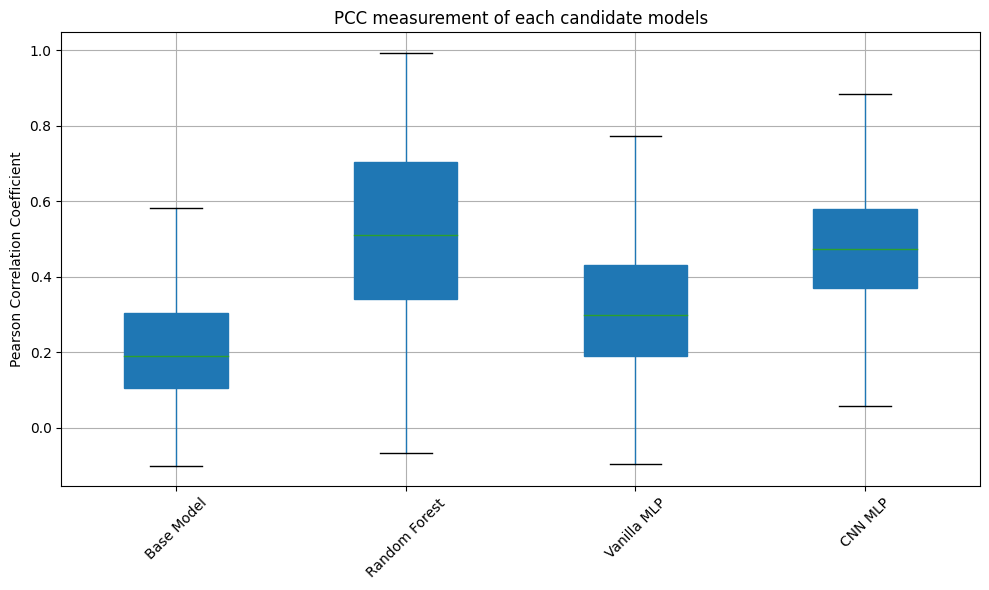

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate some example data
np.random.seed(42)
predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

# Calculate Pearson correlation coefficients for each model
correlation_model1 = np.array([np.corrcoef(row1, row2)[0, 1] for row1, row2 in zip(predicted_model1, ground_truth_data)])
correlation_model2 = np.array([np.corrcoef(row1, row2)[0, 1] for row1, row2 in zip(predicted_model2, ground_truth_data)])
correlation_model3 = np.array([np.corrcoef(row1, row2)[0, 1] for row1, row2 in zip(predicted_model3, ground_truth_data)])
correlation_model4 = np.array([np.corrcoef(row1, row2)[0, 1] for row1, row2 in zip(predicted_model4, ground_truth_data)])

# Combine the correlation coefficients into a DataFrame
data = pd.DataFrame({
    'Base Model': correlation_model1,
    'Random Forest': correlation_model2,
    'Vanilla MLP': correlation_model3,
    'CNN MLP': correlation_model4
})

# Create the figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Create the box plot
data.boxplot(ax=ax, showfliers=False, patch_artist=True)

# Customize the plot
plt.title('PCC measurement of each candidate models')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Weighted Cosine Similarity Distribution

In [118]:
def WeightedSimlarity(outputs, targets):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    weights = torch.stack([torch.arange(1, outputs.size(1)+1)] * outputs.size(0)).to(device)

    # I -> m * (I)^(0.5)
    outputs = torch.mul(torch.pow(outputs, 0.5).to(device), weights).to(device)
    targets = torch.mul(torch.pow(targets, 0.5).to(device), weights).to(device)

    return F.cosine_similarity(outputs, targets).to("cpu").numpy()

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

weighted_similarity1 = WeightedSimlarity(torch.tensor(predicted_model1), torch.tensor(ground_truth_data))
weighted_similarity2 = WeightedSimlarity(torch.tensor(predicted_model2), torch.tensor(ground_truth_data))
weighted_similarity3 = WeightedSimlarity(torch.tensor(predicted_model3), torch.tensor(ground_truth_data))
weighted_similarity4 = WeightedSimlarity(torch.tensor(predicted_model4), torch.tensor(ground_truth_data))

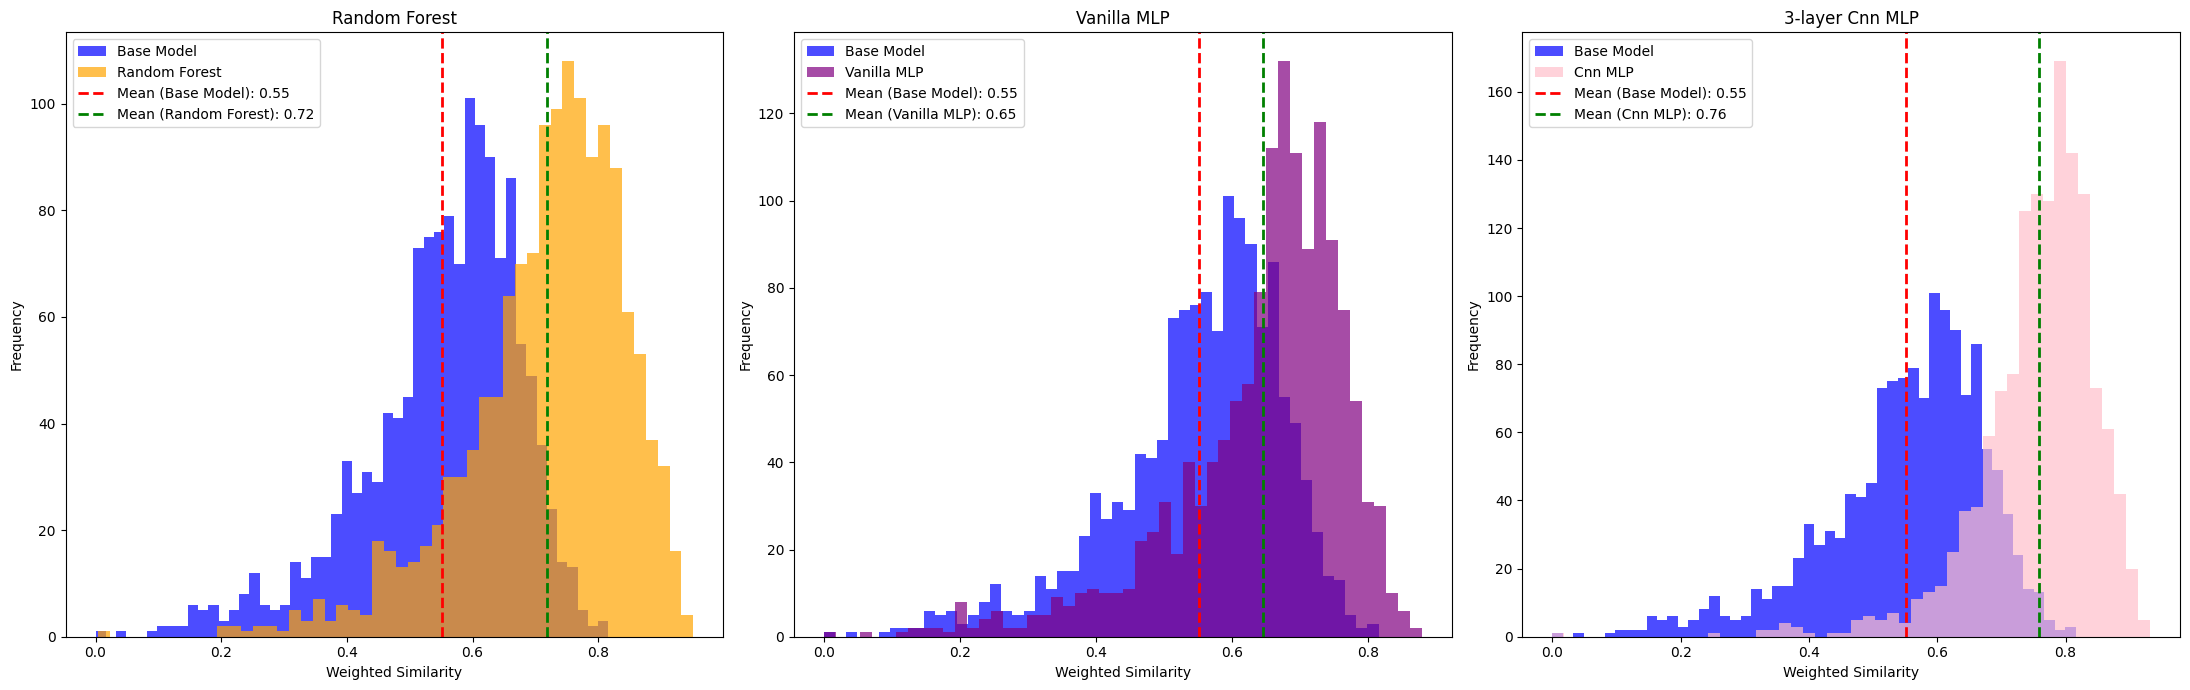

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example weighted similarity values for three lists
np.random.seed(42)
list1 = weighted_similarity1
list2 = weighted_similarity2
list3 = weighted_similarity3
list4 = weighted_similarity4

# Create a figure with subplots
plt.figure(figsize=(22, 7))

# Subplot 1
ax1 = plt.subplot(1, 3, 1)
ax1.hist(weighted_similarity1, bins=50, alpha=0.7, label='Base Model', color='blue')
ax1.hist(weighted_similarity2, bins=50, alpha=0.7, label='Random Forest', color='orange')

mean_list1 = np.mean(weighted_similarity1)
mean_list2 = np.mean(weighted_similarity2)

ax1.axvline(mean_list1, color='red', linestyle='dashed', linewidth=2, label=f'Mean (Base Model): {mean_list1:.2f}')
ax1.axvline(mean_list2, color='green', linestyle='dashed', linewidth=2, label=f'Mean (Random Forest): {mean_list2:.2f}')

ax1.set_title('Random Forest')
ax1.set_xlabel('Weighted Similarity')
ax1.set_ylabel('Frequency')
ax1.legend()

# Subplot 2
ax1 = plt.subplot(1, 3, 2)
ax1.hist(weighted_similarity1, bins=50, alpha=0.7, label='Base Model', color='blue')
ax1.hist(weighted_similarity3, bins=50, alpha=0.7, label='Vanilla MLP', color='purple')

mean_list1 = np.mean(weighted_similarity1)
mean_list2 = np.mean(weighted_similarity3)

ax1.axvline(mean_list1, color='red', linestyle='dashed', linewidth=2, label=f'Mean (Base Model): {mean_list1:.2f}')
ax1.axvline(mean_list2, color='green', linestyle='dashed', linewidth=2, label=f'Mean (Vanilla MLP): {mean_list2:.2f}')

ax1.set_title('Vanilla MLP')
ax1.set_xlabel('Weighted Similarity')
ax1.set_ylabel('Frequency')
ax1.legend()

# Subplot 3
ax1 = plt.subplot(1, 3, 3)
ax1.hist(weighted_similarity1, bins=50, alpha=0.7, label='Base Model', color='blue')
ax1.hist(weighted_similarity4, bins=50, alpha=0.7, label='Cnn MLP', color='pink')

mean_list1 = np.mean(weighted_similarity1)
mean_list2 = np.mean(weighted_similarity4)

ax1.axvline(mean_list1, color='red', linestyle='dashed', linewidth=2, label=f'Mean (Base Model): {mean_list1:.2f}')
ax1.axvline(mean_list2, color='green', linestyle='dashed', linewidth=2, label=f'Mean (Cnn MLP): {mean_list2:.2f}')

ax1.set_title('3-layer Cnn MLP')
ax1.set_xlabel('Weighted Similarity')
ax1.set_ylabel('Frequency')
ax1.legend()


# Adjust layout
plt.tight_layout()
plt.show()


### Visualised Comparison of predicted and ground-truth spectrum data

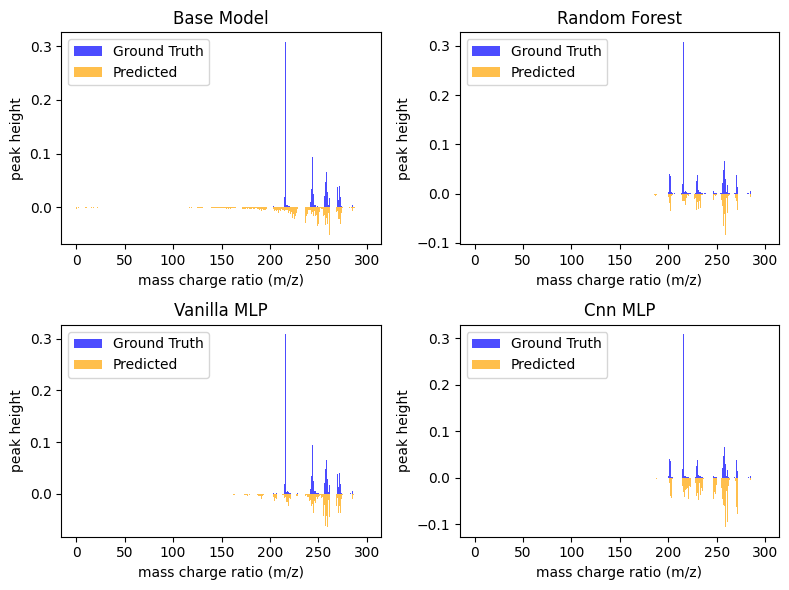

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example weighted similarity values for three lists
np.random.seed(42)
predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

index = 120

# Create a figure with subplots
plt.figure(figsize=(8, 6))

# Subplot 1
ax = plt.subplot(2, 2, 1)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model1[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Base Model')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Subplot 2
ax = plt.subplot(2, 2, 2)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model2[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Random Forest')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 3
ax = plt.subplot(2, 2, 3)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model3[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Vanilla MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 4
ax = plt.subplot(2, 2, 4)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model4[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Cnn MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


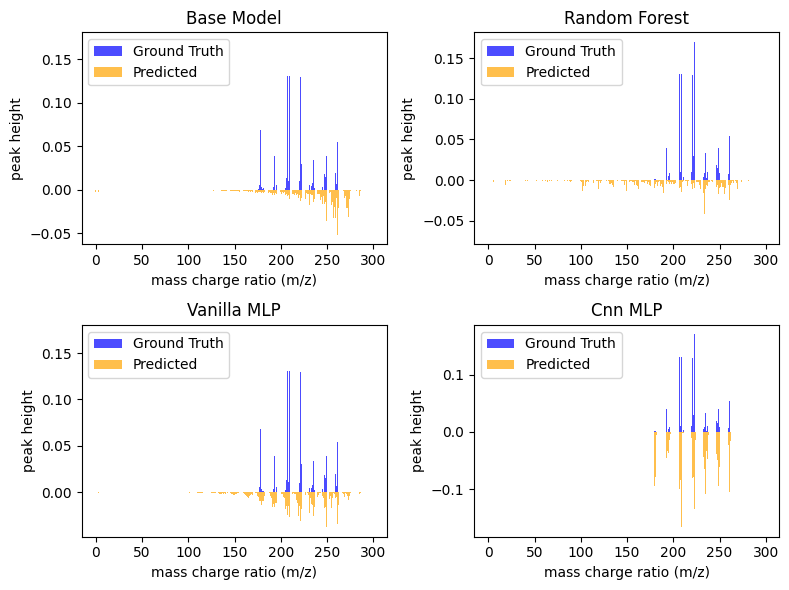

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example weighted similarity values for three lists
np.random.seed(42)
predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

index = 1200

# Create a figure with subplots
plt.figure(figsize=(8, 6))

# Subplot 1
ax = plt.subplot(2, 2, 1)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model1[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Base Model')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Subplot 2
ax = plt.subplot(2, 2, 2)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model2[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Random Forest')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 3
ax = plt.subplot(2, 2, 3)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model3[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Vanilla MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 4
ax = plt.subplot(2, 2, 4)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model4[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Cnn MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


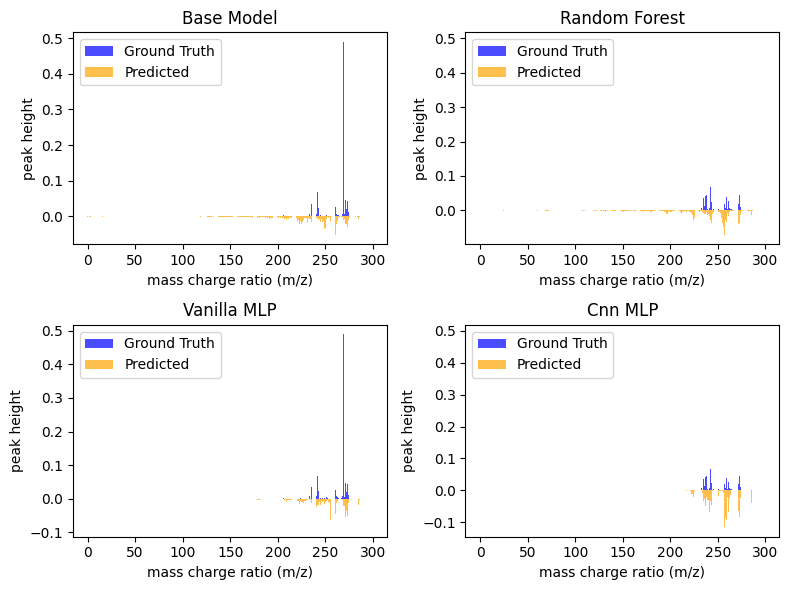

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example weighted similarity values for three lists
np.random.seed(42)
predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

index = 13

# Create a figure with subplots
plt.figure(figsize=(8, 6))

# Subplot 1
ax = plt.subplot(2, 2, 1)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model1[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Base Model')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Subplot 2
ax = plt.subplot(2, 2, 2)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model2[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Random Forest')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 3
ax = plt.subplot(2, 2, 3)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model3[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Vanilla MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 4
ax = plt.subplot(2, 2, 4)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model4[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Cnn MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

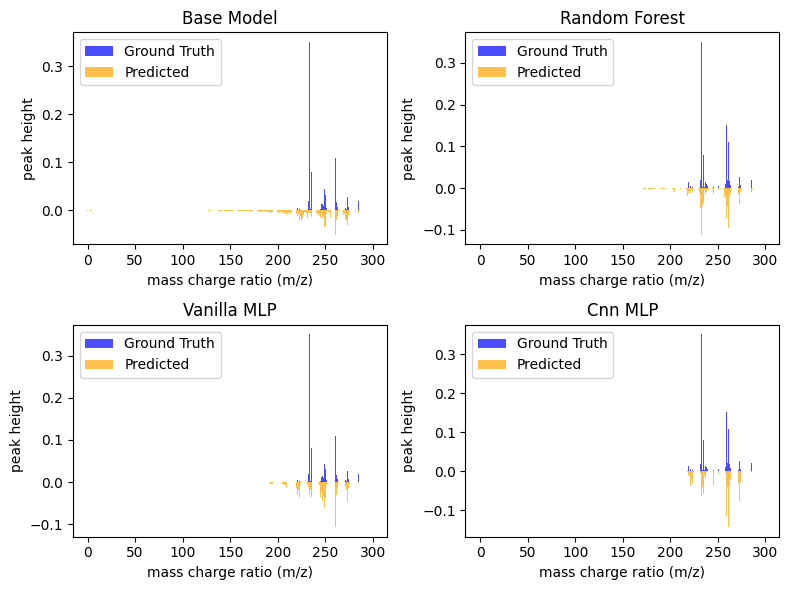

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example weighted similarity values for three lists
np.random.seed(42)
predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

index = 888

# Create a figure with subplots
plt.figure(figsize=(8, 6))

# Subplot 1
ax = plt.subplot(2, 2, 1)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model1[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Base Model')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Subplot 2
ax = plt.subplot(2, 2, 2)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model2[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Random Forest')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 3
ax = plt.subplot(2, 2, 3)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model3[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Vanilla MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 4
ax = plt.subplot(2, 2, 4)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model4[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Cnn MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

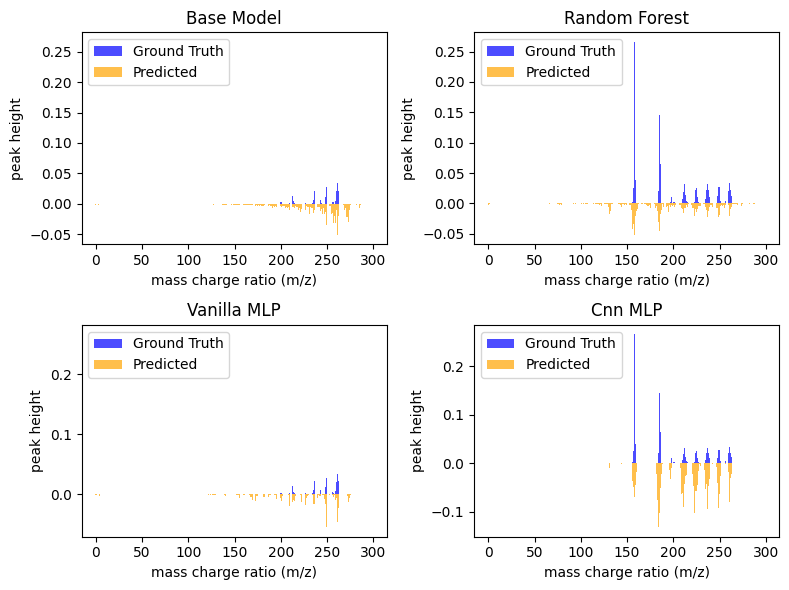

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example weighted similarity values for three lists
np.random.seed(42)
predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

index = 911

# Create a figure with subplots
plt.figure(figsize=(8, 6))

# Subplot 1
ax = plt.subplot(2, 2, 1)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model1[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Base Model')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Subplot 2
ax = plt.subplot(2, 2, 2)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model2[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Random Forest')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 3
ax = plt.subplot(2, 2, 3)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model3[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Vanilla MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 4
ax = plt.subplot(2, 2, 4)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model4[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Cnn MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

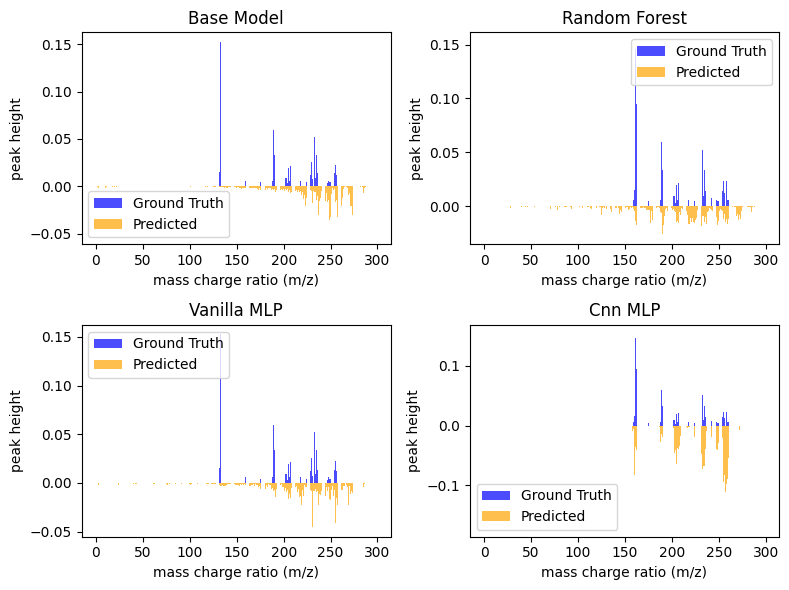

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example weighted similarity values for three lists
np.random.seed(42)
predicted_model1 = np.array(baseModelOutput)
predicted_model2 = np.array(randomForestOutput)
predicted_model3 = np.array(vanillaMLPOutput)
predicted_model4 = np.array(cnnMLPOutput)
ground_truth_data = np.array(groundTruthOutput)

index = 617

# Create a figure with subplots
plt.figure(figsize=(8, 6))

# Subplot 1
ax = plt.subplot(2, 2, 1)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model1[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Base Model')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Subplot 2
ax = plt.subplot(2, 2, 2)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model2[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Random Forest')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 3
ax = plt.subplot(2, 2, 3)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model3[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Vanilla MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()


# Subplot 4
ax = plt.subplot(2, 2, 4)
ground_truth = ground_truth_data[index]  # Adjust the index to your needs
predicted = predicted_model4[index]  # Adjust the index to your needs

# Plot the ground-truth spectrum data
ax.bar(np.arange(len(ground_truth)), ground_truth, color='blue', label='Ground Truth', alpha=0.7)
# Plot the predicted spectrum data below x-axis
ax.bar(np.arange(len(predicted)), predicted * -1, color='orange', label='Predicted', alpha=0.7)

ax.set_title('Cnn MLP')
ax.set_xlabel('mass charge ratio (m/z)')
ax.set_ylabel('peak height')
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()